In [1]:
import requests
import json
from mobfot import MobFot
from mplsoccer import Pitch
import time


import matplotlib.patheffects as path_effects

from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches
from matplotlib import cm
from highlight_text import fig_text, ax_text
from ast import literal_eval

from PIL import Image
import urllib
import os
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib import image
from PIL import Image
import urllib.request
from PIL import Image
from io import BytesIO

import pandas as pd
from bs4 import BeautifulSoup
# import klib as kb
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
# import wes
import matplotlib as mpl
import warnings
import numpy as np
from math import pi
from urllib.request import urlopen
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
from sklearn.preprocessing import StandardScaler

import requests
import pandas as pd
import warnings
import time
from bs4 import BeautifulSoup

import sys
# Add the directory containing FBREF_Aggregations.py to the Python path
module_path = os.path.abspath(os.path.join('/Users/stephenahiabah/Desktop/Code/cannoniq'))
if module_path not in sys.path:
    sys.path.append(module_path)

import FBREF_Aggregations as fbref

fb_ref_db = fbref.CreateFBRefDatabase()


In [12]:
import requests
import pandas as pd
import warnings
import time
from bs4 import BeautifulSoup

def scrape_league_wages(league_urls):
    def get_team_urls(league_url):
        soup = BeautifulSoup(requests.get(league_url).content, "html.parser")
        links = soup.select("table.stats_table a[href*='/squads/']")
        
        # Only keep unique hrefs but maintain order
        seen = set()
        unique_links = []
        for link in links:
            href = link['href']
            if href not in seen:
                seen.add(href)
                unique_links.append(href)
        
        urls = ["https://fbref.com" + href for href in unique_links]
        team_names = [href[20:-6] for href in unique_links]
        
        return pd.DataFrame({'team_names': team_names, 'urls': urls})

    def build_wage_url(team_url):
        base = team_url[:37]
        slug = team_url[37:]
        return f"{base}2024-2025/wages/{slug}-Wage-Details"

    def clean_wage_table(url):
        try:
            print(f"Scraping: {url}")
            warnings.filterwarnings("ignore")
            page = requests.get(url)
            soup = BeautifulSoup(page.content, 'html.parser')
            name = soup.find_all("span")[7].text[:-17]  # Clean team name if needed

            html_content = page.text.replace('<!--', '').replace('-->', '')
            tables = pd.read_html(html_content)
            wage_stats = tables[0]

            # Drop NaN wages
            wage_stats = wage_stats.dropna(subset=["Weekly Wages"])

            # Extract currencies
            def extract_currency(row):
                parts = row.split(" ")
                return parts[0] + " " + parts[1], parts[3], parts[4]

            wage_stats[["Pound Value", "Euro Value", "Dollar Value"]] = (
                wage_stats["Weekly Wages"].apply(extract_currency).apply(pd.Series)
            )

            # Clean £ values
            wage_stats["new_pound_value"] = (
               wage_stats["Pound Value"].str.replace(r"[£€$,]", "", regex=True).str.strip().astype(int)
            )

            # Convert to euros (approx rate, e.g. £1 = €1.17)
            # wage_stats["euro_converted"] = (wage_stats["new_pound_value"] * 1.17).round(0).astype(int)

            return wage_stats[["Player", "Nation", "Pos", "Age", "new_pound_value"]]
        except Exception as e:
            print(f"Failed to scrape {url}: {e}")
            return pd.DataFrame()

    all_league_data = []

    for league_url in league_urls:
        league_component = league_url.rstrip("/").split("/")[-1]  # e.g. 'Premier-League-Stats'
        league_name = league_component.replace("-Stats", "").replace("-", " ") 
        print(f"\nProcessing league: {league_name}")
        
        team_df = get_team_urls(league_url)
        team_df['wages_url'] = team_df['urls'].apply(build_wage_url)
        
        for wage_url in team_df['wages_url']:
            team_wages = clean_wage_table(wage_url)
            if not team_wages.empty:
                team_wages["league"] = league_name
                if league_name != "Premier League":
                    team_wages["new_pound_value"] = (team_wages["new_pound_value"] * 0.85).round(0).astype(int)
                all_league_data.append(team_wages)
            time.sleep(15)  # Respectful delay

    return pd.concat(all_league_data, ignore_index=True)


In [13]:
leagues = [
    "https://fbref.com/en/comps/9/Premier-League-Stats",
    "https://fbref.com/en/comps/12/La-Liga-Stats",
    "https://fbref.com/en/comps/20/Bundesliga-Stats",
    "https://fbref.com/en/comps/11/Serie-A-Stats",
    "https://fbref.com/en/comps/13/Ligue-1-Stats"
    ]

wages_df = scrape_league_wages(leagues)



Processing league: Premier League
Scraping: https://fbref.com/en/squads/822bd0ba/2024-2025/wages/Liverpool-Stats-Wage-Details
Scraping: https://fbref.com/en/squads/18bb7c10/2024-2025/wages/Arsenal-Stats-Wage-Details
Scraping: https://fbref.com/en/squads/b8fd03ef/2024-2025/wages/2024-2025/Manchester-City-Stats-Wage-Details
Scraping: https://fbref.com/en/squads/cff3d9bb/2024-2025/wages/2024-2025/Chelsea-Stats-Wage-Details
Scraping: https://fbref.com/en/squads/b2b47a98/2024-2025/wages/Newcastle-United-Stats-Wage-Details
Scraping: https://fbref.com/en/squads/8602292d/2024-2025/wages/Aston-Villa-Stats-Wage-Details
Scraping: https://fbref.com/en/squads/e4a775cb/2024-2025/wages/Nottingham-Forest-Stats-Wage-Details
Scraping: https://fbref.com/en/squads/d07537b9/2024-2025/wages/Brighton-and-Hove-Albion-Stats-Wage-Details
Scraping: https://fbref.com/en/squads/4ba7cbea/2024-2025/wages/Bournemouth-Stats-Wage-Details
Scraping: https://fbref.com/en/squads/cd051869/2024-2025/wages/Brentford-Stats-Wa

In [288]:
# wages_df

In [266]:

wages_df.to_csv("/Users/stephenahiabah/Desktop/Code/cannoniq/CSVs/EU_Top5_Player_Wages.csv")

In [334]:
player_db = pd.read_csv("/Users/stephenahiabah/Desktop/Code/cannoniq/CSVs/CannonIQ_DB.csv")

In [335]:
merged_df = pd.merge(wages_df, player_db, on=['Player'], how='left')
merged_df = merged_df[['Player', 'new_pound_value','Squad','league']]

In [336]:
merged_df = merged_df.dropna(subset=['Squad'])
fm_ids = pd.read_csv("/Users/stephenahiabah/Desktop/Code/cannoniq/CSVs/Top6_leagues_fotmob_ids.csv")
fm_ids = fm_ids[["team", "team_id"]]
fm_ids = fm_ids.rename(columns={'team': 'Squad'})
merged_df = merged_df.merge(fm_ids, on='Squad', how='left')
merged_df.head()

Player  new_pound_value      Squad          league  team_id
0           Mohamed Salah           350000  Liverpool  Premier League     8650
1         Virgil van Dijk           220000  Liverpool  Premier League     8650
2  Trent Alexander-Arnold           180000  Liverpool  Premier League     8650
3        Andrew Robertson           160000  Liverpool  Premier League     8650
4                 Alisson           150000  Liverpool  Premier League     8650

In [337]:
league_dfs = {
    league: df for league, df in merged_df.groupby('league')
}

# Assign each to its own variable (if present)
prem_df        = league_dfs.get('Premier League', pd.DataFrame())
ligue1_df      = league_dfs.get('Ligue 1', pd.DataFrame())
laliga_df      = league_dfs.get('La Liga', pd.DataFrame())
bundesliga_df  = league_dfs.get('Bundesliga', pd.DataFrame())
seriea_df      = league_dfs.get('Serie A', pd.DataFrame())


In [338]:
bundesliga_df

Player  new_pound_value            Squad      league  \
909                 Harry Kane           408654    Bayern Munich  Bundesliga   
910               Manuel Neuer           343269    Bayern Munich  Bundesliga   
911              Thomas Müller           335096    Bayern Munich  Bundesliga   
912             Joshua Kimmich           318750    Bayern Munich  Bundesliga   
913               Serge Gnabry           308452    Bayern Munich  Bundesliga   
914             Kingsley Coman           277885    Bayern Munich  Bundesliga   
915                 Leroy Sané           245193    Bayern Munich  Bundesliga   
916              Michael Olise           220673    Bayern Munich  Bundesliga   
917              Leon Goretzka           212500    Bayern Munich  Bundesliga   
918                Kim Min-jae           196154    Bayern Munich  Bundesliga   
919            Alphonso Davies           183894    Bayern Munich  Bundesliga   
920            Dayot Upamecano           163462    Bayern Munich  Bundesliga   
921              João Palhinha           163462    Bayern Munich  Bundesliga   
922              Konrad Laimer           147115    Bayern Munich  Bundesliga   
923          Raphaël Guerreiro           130769    Bayern Munich  Bundesliga   
924             Josip Stanišić           107885    Bayern Munich  Bundesliga   
925              Jamal Musiala            81731    Bayern Munich  Bundesliga   
926                 Mathys Tel            81731        Tottenham  Bundesliga   
927                  Eric Dier            81731    Bayern Munich  Bundesliga   
928                 Hiroki Ito            61788    Bayern Munich  Bundesliga   
929                 Sacha Boey            49038    Bayern Munich  Bundesliga   
930               Sven Ulreich            32693    Bayern Munich  Bundesliga   
931        Aleksandar Pavlovic            29423    Bayern Munich  Bundesliga   
932              Daniel Peretz            24519    Bayern Munich  Bundesliga   
933         Arijon Ibrahimović            24519            Lazio  Bundesliga   
934                 Adam Aznou             4577       Valladolid  Bundesliga   
935              Álex Grimaldo            98077       Leverkusen  Bundesliga   
936              Patrik Schick            98077       Leverkusen  Bundesliga   
937             Edmond Tapsoba            81731       Leverkusen  Bundesliga   
938          Exequiel Palacios            81731       Leverkusen  Bundesliga   
939               Aleix García            77154       Leverkusen  Bundesliga   
940              Florian Wirtz            73557       Leverkusen  Bundesliga   
941               Granit Xhaka            67837       Leverkusen  Bundesliga   
942           Jeremie Frimpong            65385       Leverkusen  Bundesliga   
943              Jonas Hofmann            65385       Leverkusen  Bundesliga   
944             Piero Hincapié            61788       Leverkusen  Bundesliga   
945                 Amine Adli            55577       Leverkusen  Bundesliga   
946             Martin Terrier            55577       Leverkusen  Bundesliga   
947             Robert Andrich            52307       Leverkusen  Bundesliga   
948               Jonathan Tah            46260       Leverkusen  Bundesliga   
949             Lukáš Hrádecký            42500       Leverkusen  Bundesliga   
950            Victor Boniface            32693       Leverkusen  Bundesliga   
951               Nathan Tella            29423       Leverkusen  Bundesliga   
952                Matej Kovar            12260       Leverkusen  Bundesliga   
953           Jeanuël Belocian            12260       Leverkusen  Bundesliga   
954                     Arthur            11769       Leverkusen  Bundesliga   
955              Arthur Theate            59500   Eint Frankfurt  Bundesliga   
956                Mario Götze            57212   Eint Frankfurt  Bundesliga   
957                Kevin Trapp            57212   Eint Frankfurt  Bundesliga   
958               Hugo E

In [339]:
team_to_league = {
    # Premier League
    'Arsenal': 'Premier League',
    'Aston Villa': 'Premier League',
    'Bournemouth': 'Premier League',
    'Brentford': 'Premier League',
    'Brighton': 'Premier League',
    'Chelsea': 'Premier League',
    'Crystal Palace': 'Premier League',
    'Everton': 'Premier League',
    'Fulham': 'Premier League',
    'Ipswich Town': 'Premier League',
    'Leicester City': 'Premier League',
    'Liverpool': 'Premier League',
    'Manchester City': 'Premier League',
    'Manchester Utd': 'Premier League',
    "Nott'ham Forest": 'Premier League',
    'Newcastle Utd': 'Premier League',
    'Southampton': 'Premier League',
    'Tottenham': 'Premier League',
    'West Ham': 'Premier League',
    'Wolves': 'Premier League',

    # La Liga
    'Alavés': 'La Liga',
    'Athletic Club': 'La Liga',
    'Atlético Madrid': 'La Liga',
    'Barcelona': 'La Liga',
    'Celta Vigo': 'La Liga',
    'Espanyol': 'La Liga',
    'Getafe': 'La Liga',
    'Girona': 'La Liga',
    'Las Palmas': 'La Liga',
    'Leganés': 'La Liga',
    'Mallorca': 'La Liga',
    'Osasuna': 'La Liga',
    'Rayo Vallecano': 'La Liga',
    'Real Madrid': 'La Liga',
    'Real Sociedad': 'La Liga',
    'Sevilla': 'La Liga',
    'Valencia': 'La Liga',
    'Valladolid': 'La Liga',
    'Villarreal': 'La Liga',

    # Serie A
    'Atalanta': 'Serie A',
    'Bologna': 'Serie A',
    'Cagliari': 'Serie A',
    'Empoli': 'Serie A',
    'Fiorentina': 'Serie A',
    'Genoa': 'Serie A',
    'Hellas Verona': 'Serie A',
    'Inter': 'Serie A',
    'Juventus': 'Serie A',
    'Lazio': 'Serie A',
    'Lecce': 'Serie A',
    'Milan': 'Serie A',
    'Monza': 'Serie A',
    'Napoli': 'Serie A',
    'Roma': 'Serie A',
    'Salernitana': 'Serie A',  # not in your list, but might be worth adding
    'Sassuolo': 'Serie A',     # same
    'Torino': 'Serie A',
    'Udinese': 'Serie A',
    'Venezia': 'Serie A',
    'Como': 'Serie A',
    'Parma': 'Serie A',

    # Bundesliga
    'Augsburg': 'Bundesliga',
    'Bayern Munich': 'Bundesliga',
    'Bochum': 'Bundesliga',
    'Dortmund': 'Bundesliga',
    'Eint Frankfurt': 'Bundesliga',
    'Freiburg': 'Bundesliga',
    'Gladbach': 'Bundesliga',
    'Heidenheim': 'Bundesliga',
    'Hoffenheim': 'Bundesliga',
    'Leverkusen': 'Bundesliga',
    'Mainz 05': 'Bundesliga',
    'RB Leipzig': 'Bundesliga',
    'Stuttgart': 'Bundesliga',
    'Union Berlin': 'Bundesliga',
    'Werder Bremen': 'Bundesliga',
    'Wolfsburg': 'Bundesliga',
    'St. Pauli': 'Bundesliga',
    'Holstein Kiel': 'Bundesliga',

    # Ligue 1
    'Angers': 'Ligue 1',
    'Auxerre': 'Ligue 1',
    'Brest': 'Ligue 1',
    'Le Havre': 'Ligue 1',
    'Lens': 'Ligue 1',
    'Lille': 'Ligue 1',
    'Lyon': 'Ligue 1',
    'Marseille': 'Ligue 1',
    'Metz': 'Ligue 1',  # might be relevant later
    'Monaco': 'Ligue 1',
    'Montpellier': 'Ligue 1',
    'Nantes': 'Ligue 1',
    'Nice': 'Ligue 1',
    'Paris S-G': 'Ligue 1',
    'Reims': 'Ligue 1',
    'Rennes': 'Ligue 1',
    'Saint-Étienne': 'Ligue 1',
    'Strasbourg': 'Ligue 1',
    'Toulouse': 'Ligue 1',
}


In [419]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as path_effects
from matplotlib import image
from PIL import Image
import urllib
from highlight_text import ax_text, fig_text
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


def generate_wage_distribution_chart(merged_df, csv_path, league_name, chart_title, league_logo_path, piq_logo_path,team_to_league):
    # Step 1: Merge with FotMob team IDs
    fm_ids = pd.read_csv(csv_path)[["team", "team_id"]].rename(columns={'team': 'Squad'})
    # merged_df = merged_df.merge(fm_ids, on='Squad', how='left')
    merged_df["team_id"] = merged_df["team_id"].fillna(-1).astype(int)
    merged_df['league'] = merged_df['Squad'].map(team_to_league)
    merged_df = merged_df[merged_df['league'] == league_name].copy()

    team_names = pd.read_csv(csv_path)
    wage_dist = pd.merge(merged_df, team_names, on='team_id')
    wage_dist = wage_dist[["Player", "new_pound_value", "team_id", "team", "league"]].drop_duplicates(subset=["Player"])

    

    # Step 2: Bin player wages
    bin_labels = ["<£10k", "£10k-£50k", "£50k-£80k", "£80k-£100k", "£100k-£150k", "£150k-£200k", "£200k+"]
    bin_edges = [0, 10000, 50000, 80000, 100000, 150000, 200000, 500000]
    wage_dist["Wage_Bin"] = pd.cut(wage_dist["new_pound_value"], bins=bin_edges, labels=bin_labels, include_lowest=True)
    wage_dist.dropna(subset=["Wage_Bin"], inplace=True)
    bin_counts = wage_dist.groupby(["team", "Wage_Bin"]).size().reset_index(name="Count")
    wage_dist = wage_dist.merge(bin_counts, on=["team", "Wage_Bin"], how="left")
    # Step 3: Filter wage bill for that league
    wage_bill = wage_dist.groupby(['team','team_id'])['new_pound_value'].sum().reset_index()
  

    # Step 4: Fill in missing bins
    aggregated_df = wage_dist.groupby(['team', 'Wage_Bin']).size().reset_index(name='Count')
    # print(aggregated_df)
    all_bins = bin_labels
    result_dfs = []
    for team in aggregated_df['team'].unique():
        team_data = aggregated_df[aggregated_df['team'] == team]
        bin_template = pd.DataFrame({'Wage_Bin': all_bins})
        filled = bin_template.merge(team_data, on='Wage_Bin', how='left').fillna(0)
        filled['team'] = team
        result_dfs.append(filled)
    aggregated_df = pd.concat(result_dfs, ignore_index=True)[['team', 'Wage_Bin', 'Count']]
    aggregated_df['Wage_Bin'] = pd.Categorical(aggregated_df['Wage_Bin'], categories=all_bins, ordered=True)
    aggregated_df = aggregated_df.sort_values(by=['team', 'Wage_Bin'])
    # print(aggregated_df)

    # Step 5: Merge in team_id and color
    team_ids = pd.read_csv(csv_path)[['team','team_id']]
    # wage_bill_rank = pd.merge(wage_bill, team_ids, on='team', how='left')
    wage_bill_rank = wage_bill.copy()
    # team_name_list = wage_bill_rank.team.unique().tolist()
    wage_bill_rank = wage_bill_rank.sort_values(by='new_pound_value', ascending=False).reset_index(drop=True)
    team_name_list = wage_bill_rank['team'].tolist()
    # print(wage_bill_rank.head())

    # print(team_name_list)
    colors = ['#302028', '#206890', '#085898', '#375196', '#FF3333', '#085098', '#005898',
              '#330000', '#005090', '#007838', '#0C2044', '#0044CC', '#FF6600', '#FF3399',
              '#00CC99', '#9900FF', '#FF00CC', '#66FF33', '#FFCC00', '#3399FF']
    color_dict = dict(zip(team_name_list, colors))
    # team_list = wage_bill_rank.team_id.tolist()
    team_list = wage_bill_rank.sort_values(by='new_pound_value', ascending=False)['team_id'].tolist()
    aggregated_df = pd.merge(aggregated_df, team_ids, on="team", how="left")
    aggregated_df["teamColor"] = aggregated_df["team"].map(color_dict)

    def plot_barchart_wages(ax, team_id, color,aggregated_df ,labels_x = False, labels_y = False):
        '''
        This function plots the bar chart showing the proportion
        of goals and xG created by each side in a specific interval of time.

        Args:
            ax (object): the matplotlib ax object
            teamId (int): the Fotmob team id
            color (str): the HEX color string to use for the plot
        '''

        # global aggregated_df

        data = aggregated_df.copy()
        data = data[data["team_id"] == team_id].reset_index(drop = True)

        ax.spines["right"].set_visible(False)
        ax.spines['left'].set_visible(True)
        ax.spines["top"].set_visible(False)

        # Set border properties for the subplot
        border_width = 0.5
        border_color = 'black'

        ax.spines['top'].set_linewidth(border_width)  # Top border width
        ax.spines['top'].set_color(border_color)  # Top border color

        ax.spines['bottom'].set_linewidth(border_width)  # Bottom border width
        ax.spines['bottom'].set_color(border_color)  # Bottom border color

        ax.spines['left'].set_linewidth(border_width)  # Left border width
        ax.spines['left'].set_color(border_color)  # Left border color

        ax.spines['right'].set_linewidth(border_width)  # Right border width
        ax.spines['right'].set_color(border_color)  # Right border color


        ax.xaxis.set_visible(True)
        ax.yaxis.set_visible(True)

        ax.grid(True, lw = 1, ls = '--', color = "lightgrey")
        
        ax.bar(
            data.index,
            data["Count"],
            color = color,
            alpha = 0.6,
            zorder = 3,
            width = .65
        )
        ax.bar(
            data.index,
            data["Count"],
            color = color,
            width = 0.25,
            zorder =3
        )




        ax.set_xticks(data.index)
        # if labels_x:
        #     labels = ["<£10k", "£10k-£50k", "£50k-£80k", "£80k-£100k", "£100k-£150k", "£150k-£200k", "£200k+"]
        #     ax.set_xticklabels(labels, fontsize=9, rotation=45, ha='right', va='top')
        # else:
        #     ax.set_xticklabels([])

        if labels_x and len(data.index) == 7:
            ax.set_xticks(data.index)
            labels = ["<£10k", "£10k-£50k", "£50k-£80k", "£80k-£100k", "£100k-£150k", "£150k-£200k", "£200k+"]
            ax.set_xticklabels(labels, fontsize=9, rotation=45, ha='right', va='top')
        else:
            ax.set_xticks(data.index)
            ax.set_xticklabels([])

        ax.set_ylim(0,30)
        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))

        if labels_y == False:
            ax.set_yticklabels([])




        # ---- Nice touches to the viz
        ax.plot([2.5, 2.5], [0, .5], color = "gray", lw = 1.15, ls = "--")

        for index, height in enumerate(data["Count"]):
            if height != 0:
                text_ = ax.annotate(
                    xy = (index, height),
                    text = f"{height:.0f}",
                    xytext = (0, 7.5),
                    textcoords = "offset points",
                    ha = "center",
                    va = "center",
                    size = 10,
                    weight = "bold",
                    color = "black"
                )
                text_.set_path_effects(
                    [path_effects.Stroke(linewidth=1.75, foreground="white"), path_effects.Normal()])
            else:
                text_ = ax.annotate(
                    xy = (index, height),
                    text = " ",
                    xytext = (0, 7.5),
                    textcoords = "offset points",
                    ha = "center",
                    va = "center",
                    size = 10,
                    weight = "bold",
                    color = "black"
                )
                text_.set_path_effects(
                    [path_effects.Stroke(linewidth=1.75, foreground="white"), path_effects.Normal()]
            
                )

        return ax


    df = aggregated_df
    fig = plt.figure(figsize=(18, 14), dpi = 200)
    team_list = wage_bill_rank.team_id.tolist()
    num_teams = len(team_list)
    ncols = 5
    nrows = 2 * ((num_teams + ncols - 1) // ncols)
    # nrows = 8
    # ncols = 5

    gspec = gridspec.GridSpec(
        ncols=ncols, nrows=nrows, figure=fig, 
        height_ratios = [(1/nrows)*2. if x % 2 != 0 else (1/nrows)/2. for x in range(nrows)], hspace = 0.3
    )
    teams = team_list
    plot_counter = 0
    logo_counter = 0
    for row in range(nrows):
        for col in range(ncols):
            # if row % 2 != 0:
            #     ax = plt.subplot(
            #         gspec[row, col]
            #     )
            #     teamId = teams[plot_counter]
            if row % 2 != 0:
                if plot_counter >= len(teams):
                    continue
                ax = plt.subplot(gspec[row, col])
                # print("Trying team_id:", teamId)
                # print("Available team_ids in df:", df['team_id'].unique())
                # print("Row match:", df[df["team_id"] == teamId])
                teamId = teams[plot_counter]
                teamcolor = df[df["team_id"] == teamId]["teamColor"].iloc[0]
                if col == 0:
                    labels_y = True
                else:
                    labels_y = False
                if row == nrows - 1:
                    labels_x = True
                else:
                    labels_x = False
                plot_barchart_wages(ax, teamId, teamcolor,aggregated_df ,labels_x, labels_y)           
                plot_counter += 1
            # else:
            #     teamId = teams[logo_counter]
            else:
                if logo_counter >= len(teams):
                    continue
                # teamId = teams[logo_counter]
                df["team_id"] = df["team_id"].fillna(-1).astype(int)
                teamId = int(teams[logo_counter])
                teamName = df[df["team_id"] == teamId]["team"].iloc[0]
                wages = wage_bill_rank[wage_bill_rank["team_id"] == teamId]["new_pound_value"].sum()/1000000
                fotmob_url = "https://images.fotmob.com/image_resources/logo/teamlogo/"
                logo_ax = plt.subplot(gspec[row,col],anchor = "NW", facecolor = "#EFE9E6")
                club_icon = Image.open(urllib.request.urlopen(f"{fotmob_url}{teamId:.0f}.png"))
                logo_ax.imshow(club_icon)
                logo_ax.axis("off")
                ax_text(x = 1.1, y = 0.76,s = f"{teamName}",ax = logo_ax, weight = "bold", ha = "left", size = 13, annotationbbox_kw = {"xycoords":"axes fraction"})
                ax_text(x = 1.1,y = 0.18,s = f"Total Wage Bill: £{wages:.2f}m p/w",ax = logo_ax, weight = "normal", ha = "left", size = 10, annotationbbox_kw = {"xycoords":"axes fraction"})
                logo_counter += 1



    fig_text(x=0.5, y=1, s=chart_title, va="bottom", ha="center", fontsize=30, color="black", weight="bold")
    fig_text(
        x=0.5, y=0.94,
        s=f"Player Wages per {league_name} squad grouped in bands of increasing <£50k increments>.\nData from Capology via FBREF | Season 2024/2025 | viz by @pitchiq.bsky.social\n<Labels> denote the count of players in each band",
        va="bottom", ha="center", fontsize=14, color="#4E616C"
    )

    ax2 = fig.add_axes([0.1, 0.55, 0.07, 0.85])
    ax2.axis('off')
    ax2.imshow(image.imread(league_logo_path))

    ax3 = fig.add_axes([0.87, 0.55, 0.09, 0.85])
    ax3.axis('off')
    ax3.imshow(image.imread(piq_logo_path))

    output_dir = "/Users/stephenahiabah/Desktop/Code/cannoniq/Financial Analysis/Wage Charts/"
    os.makedirs(output_dir, exist_ok=True)

    fig.savefig(f"{output_dir}{league_name}_Wage_Distribution.png", bbox_inches='tight', dpi=400)

    plt.show()


In [420]:
LEAGUE_CONFIG = {
    "Premier League": {
        "logo_path": "/Users/stephenahiabah/Desktop/Code/cannoniq/Images/premier-league-2-logo.png",
        "title": "How are Premier League Wages Distributed?",
    },
    "La Liga": {
        "logo_path": "/Users/stephenahiabah/Desktop/Code/cannoniq/Images/LaLiga_logo.png",
        "title": "How are La Liga Wages Distributed?",
    },
    "Ligue 1": {
        "logo_path": "/Users/stephenahiabah/Desktop/Code/cannoniq/Images/Ligue_1_2024_Logo.png",
        "title": "How are Ligue 1 Wages Distributed?",
    },    
    "Bundesliga": {
        "logo_path": "/Users/stephenahiabah/Desktop/Code/cannoniq/Images/Bundesliga_logo.png",
        "title": "How are Bundesliga Wages Distributed?",
    },
    "Serie A": {
        "logo_path": "/Users/stephenahiabah/Desktop/Code/cannoniq/Images/Serie_A.png",
        "title": "How are Serie A Wages Distributed?",
    },

}

In [425]:
def run_wage_chart_for_league(league_name, merged_df, team_to_league):
    config = LEAGUE_CONFIG.get(league_name)
    if not config:
        raise ValueError(f"No config found for {league_name}. Please update LEAGUE_CONFIG.")

    generate_wage_distribution_chart(
        merged_df=merged_df,
        csv_path="/Users/stephenahiabah/Desktop/Code/cannoniq/CSVs/Top6_leagues_fotmob_ids.csv",
        league_name=league_name,
        chart_title=config["title"],
        league_logo_path=config["logo_path"],
        piq_logo_path="/Users/stephenahiabah/Desktop/Code/cannoniq/Images/piqmain.png",
        team_to_league=team_to_league
    )


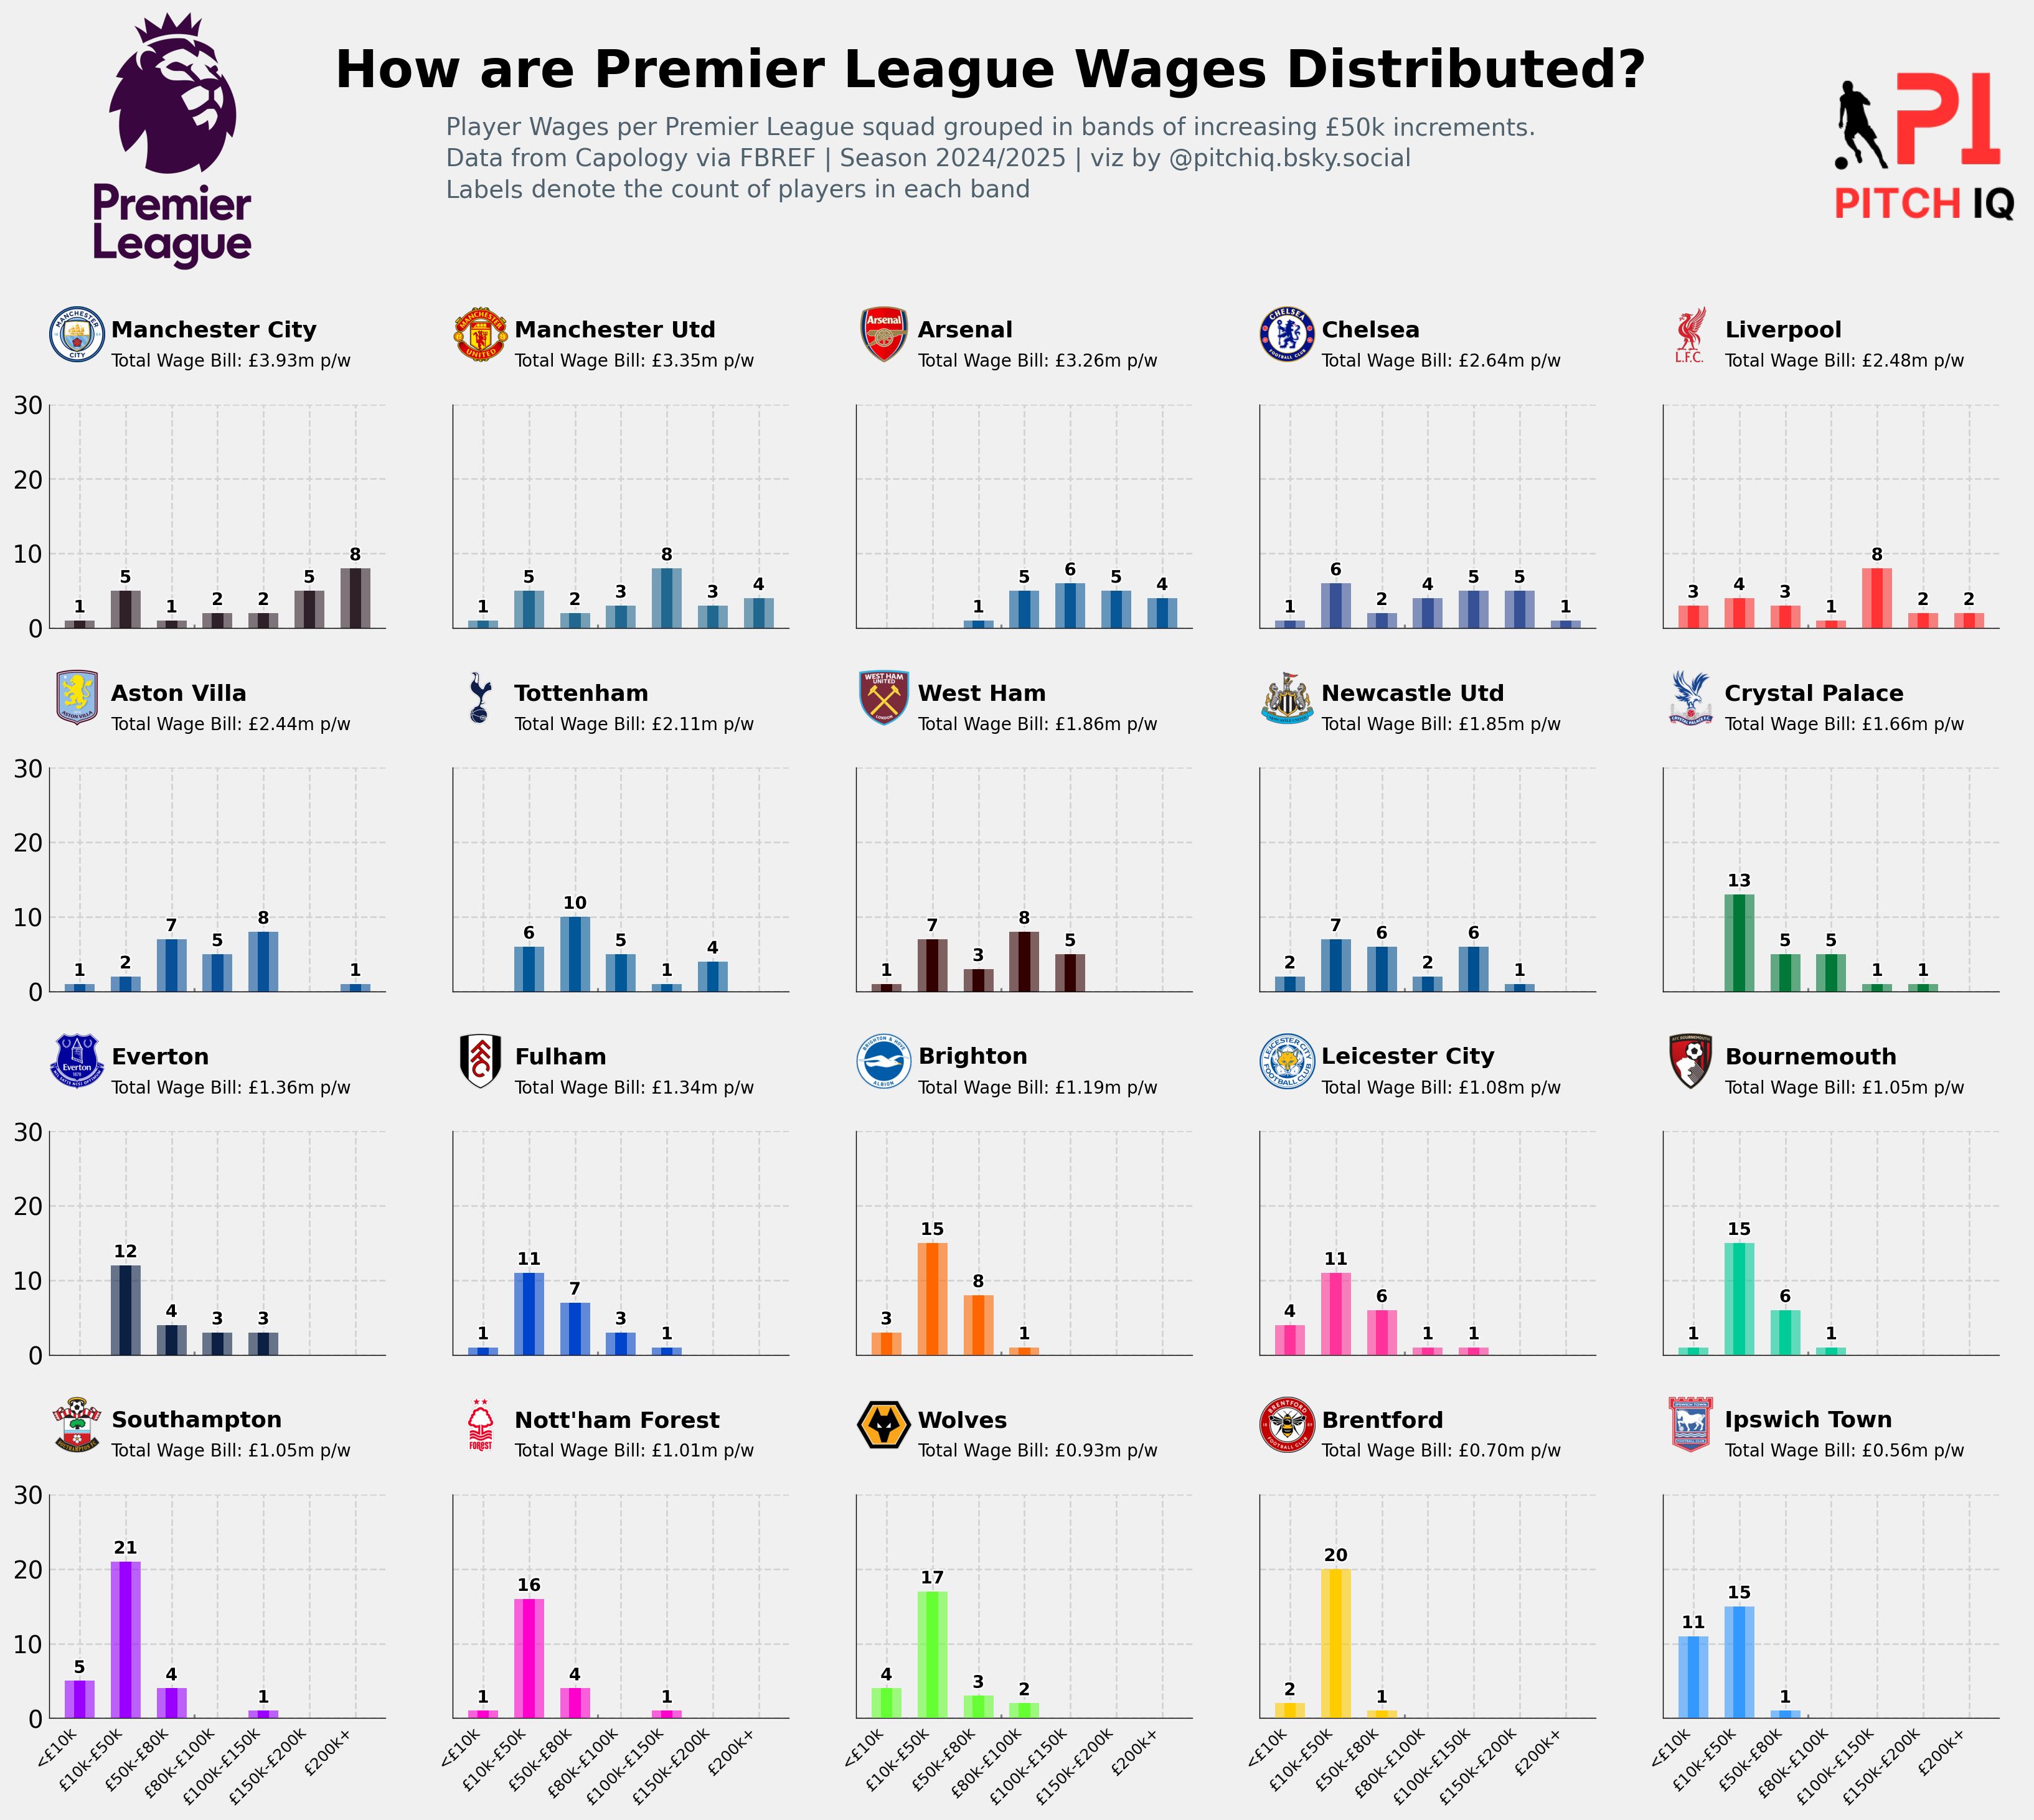

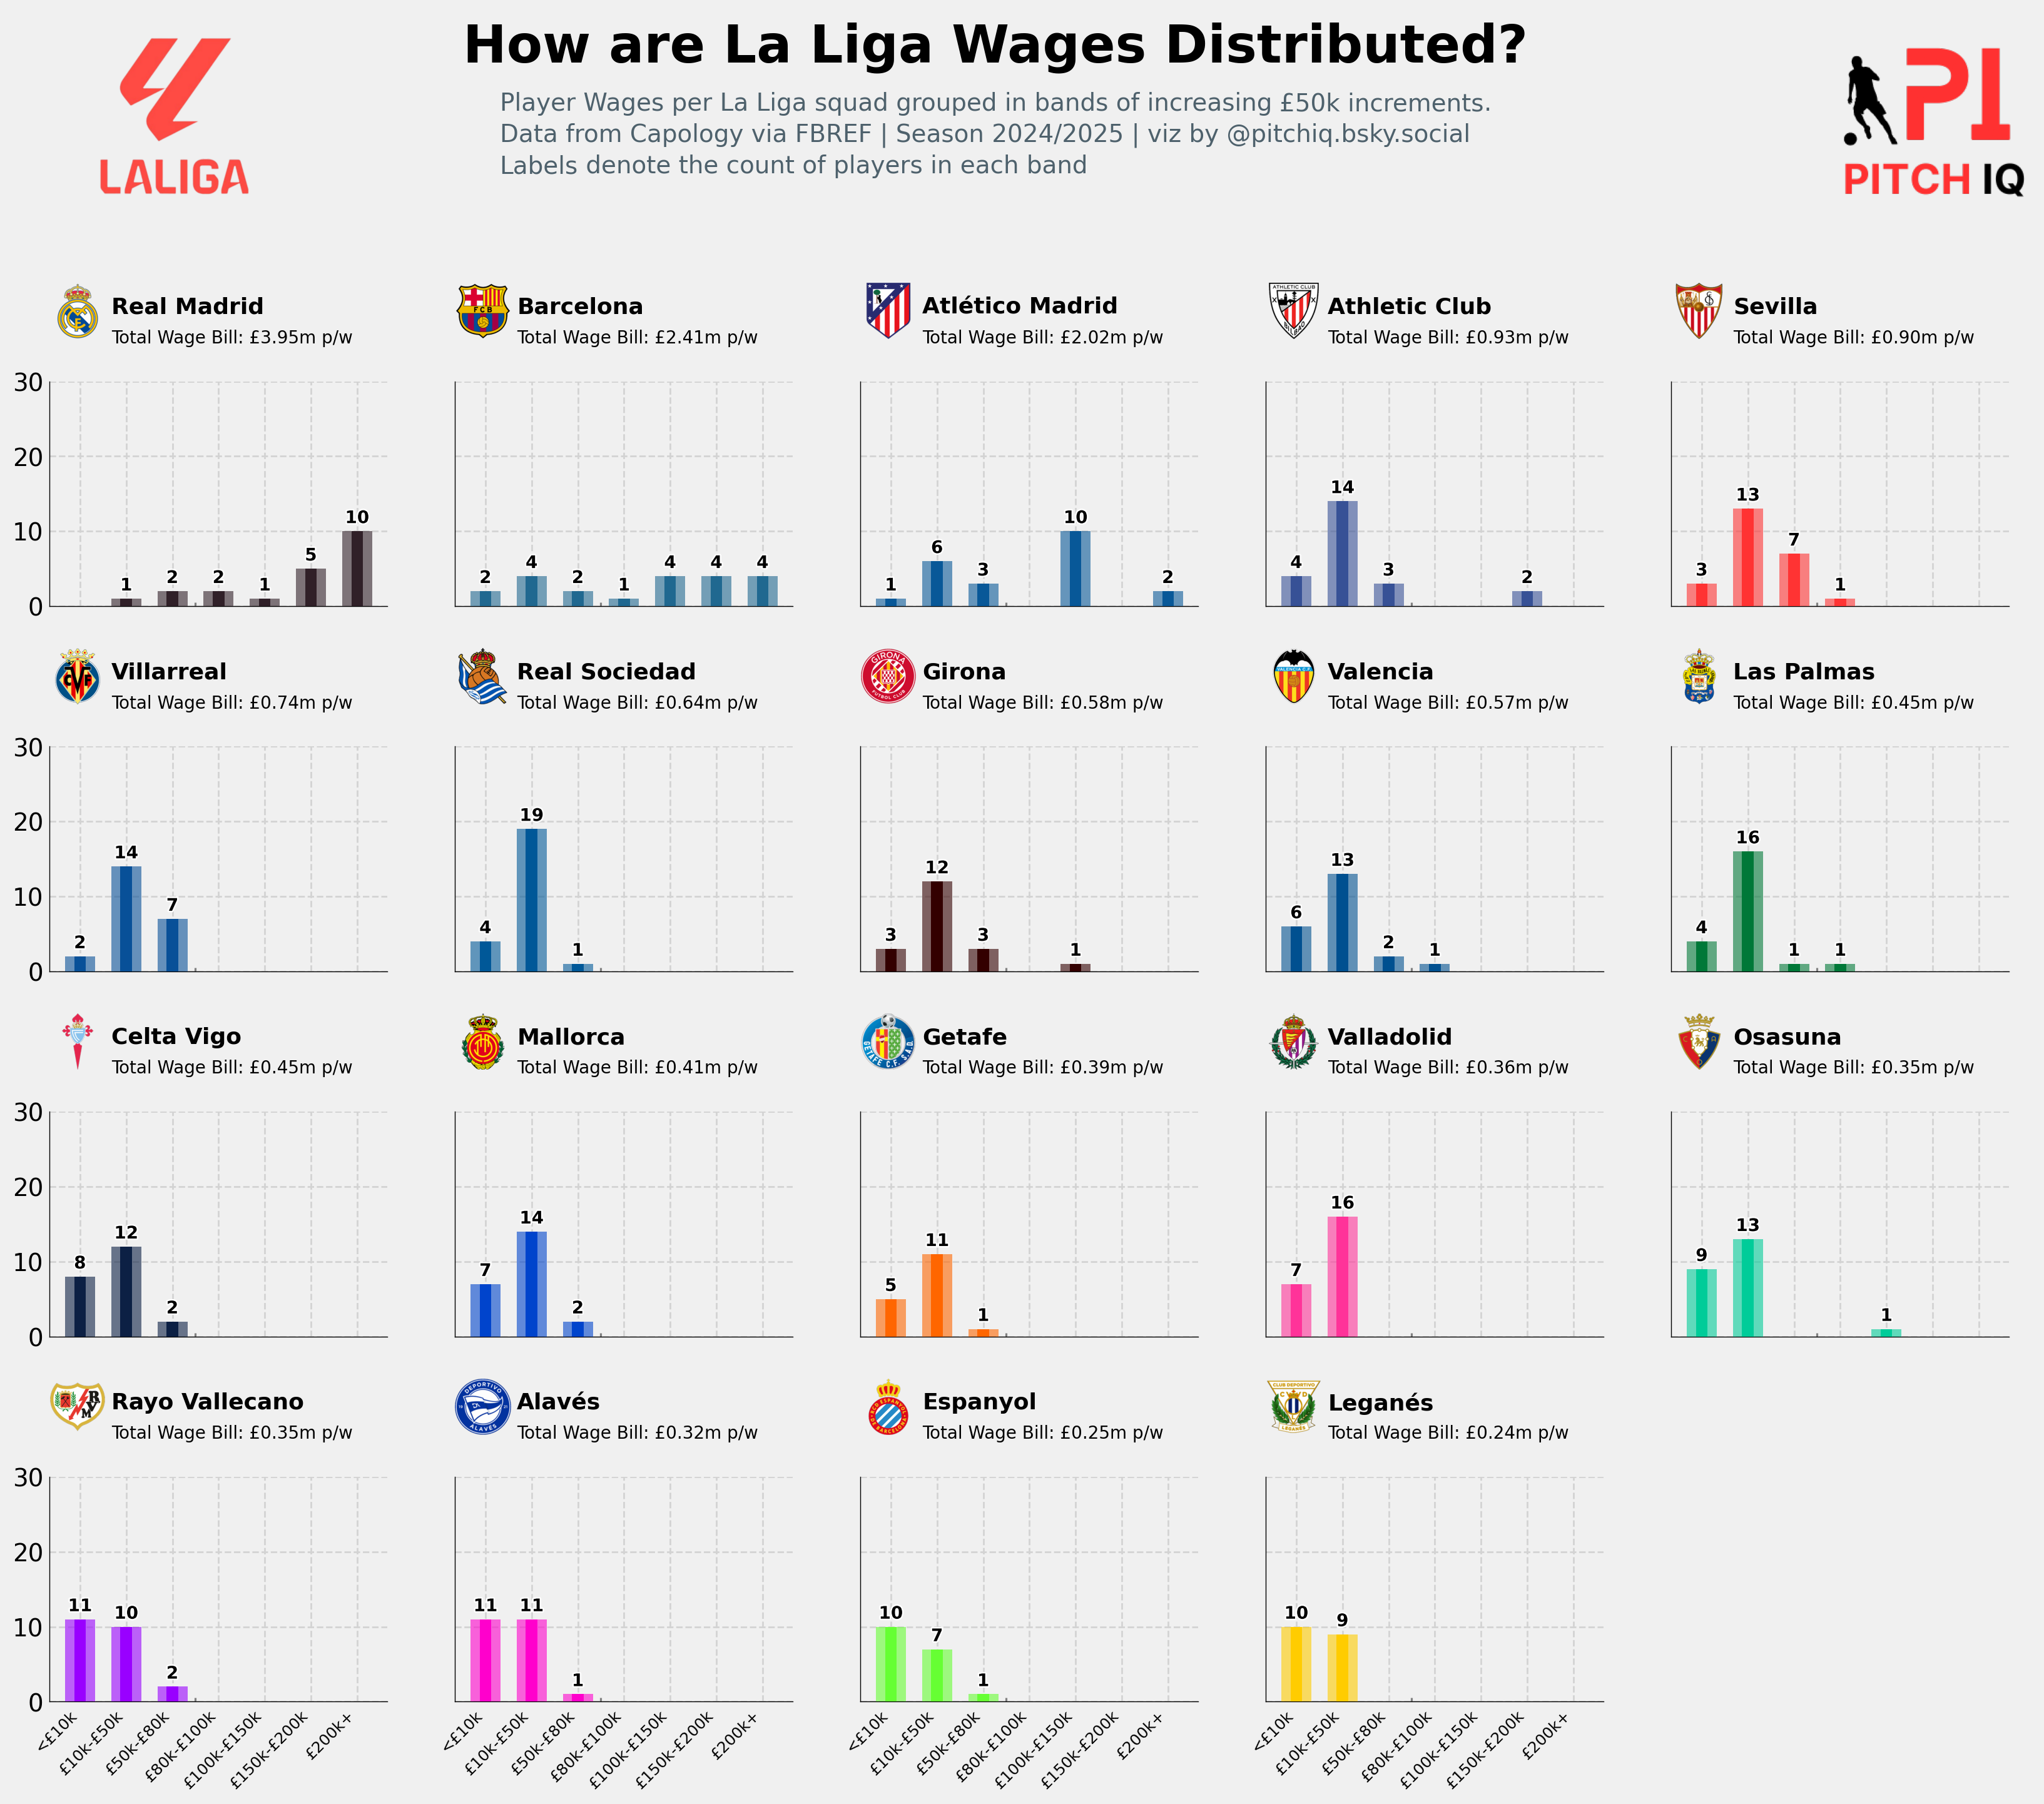

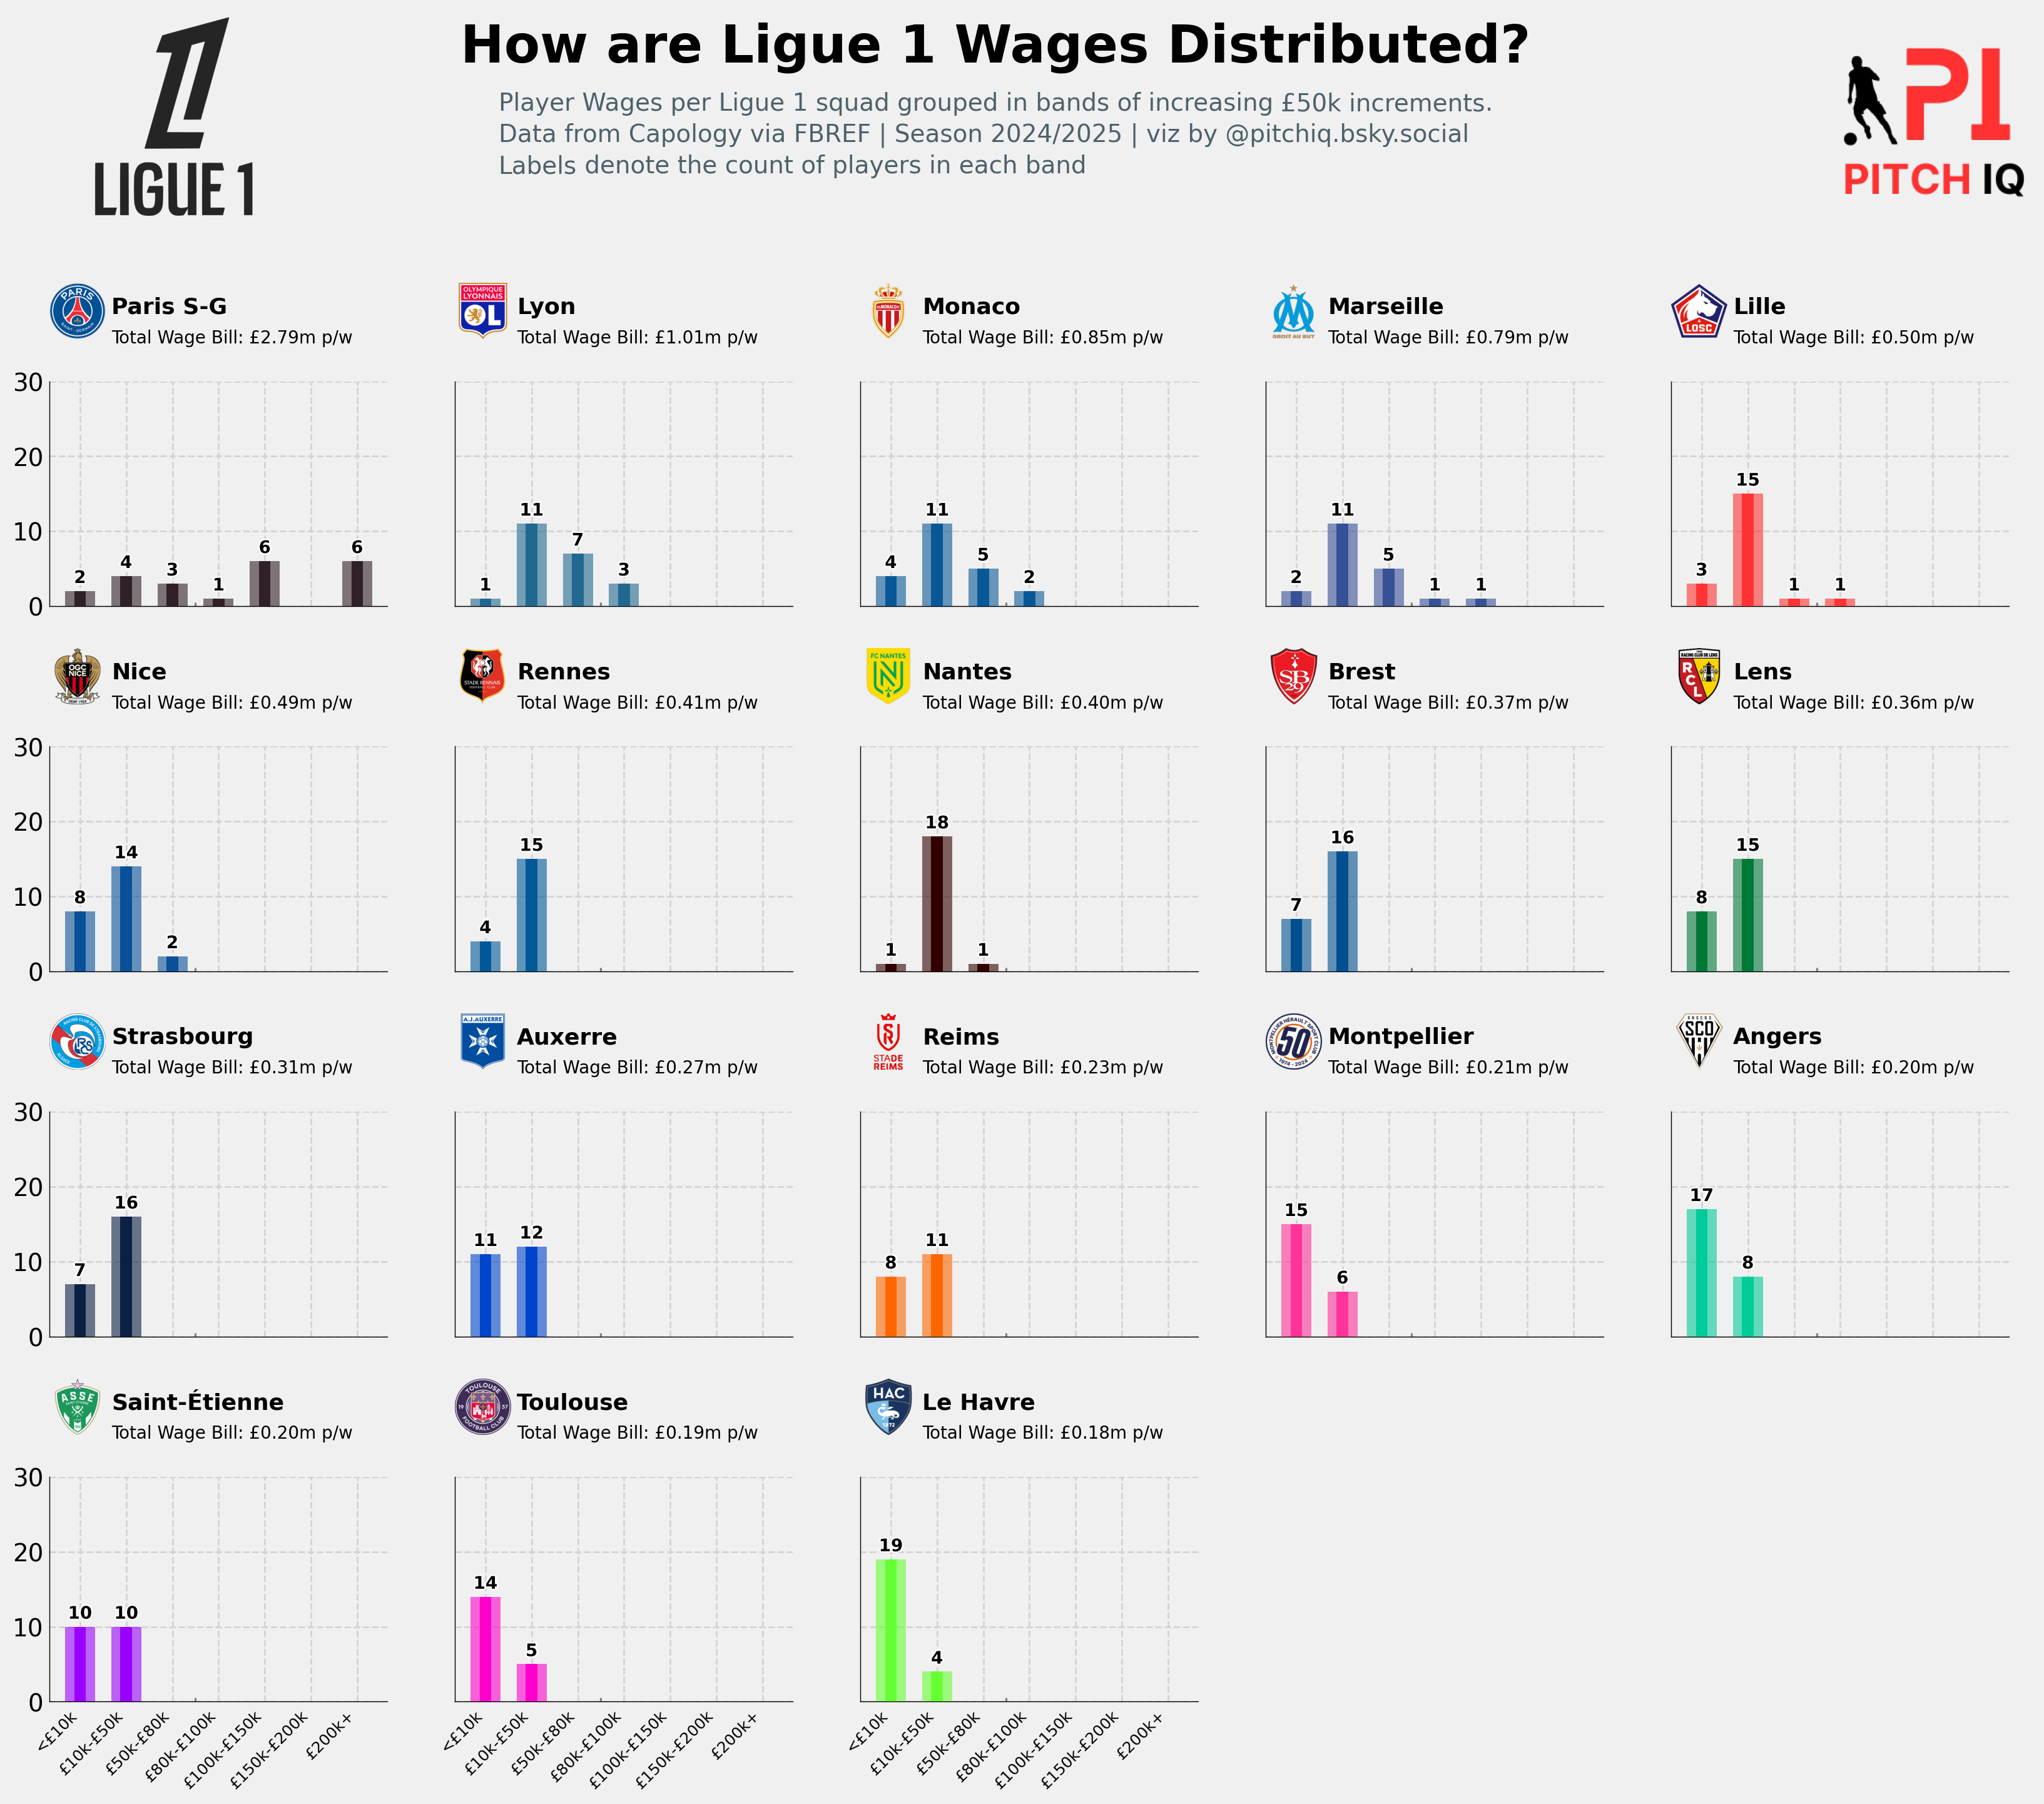

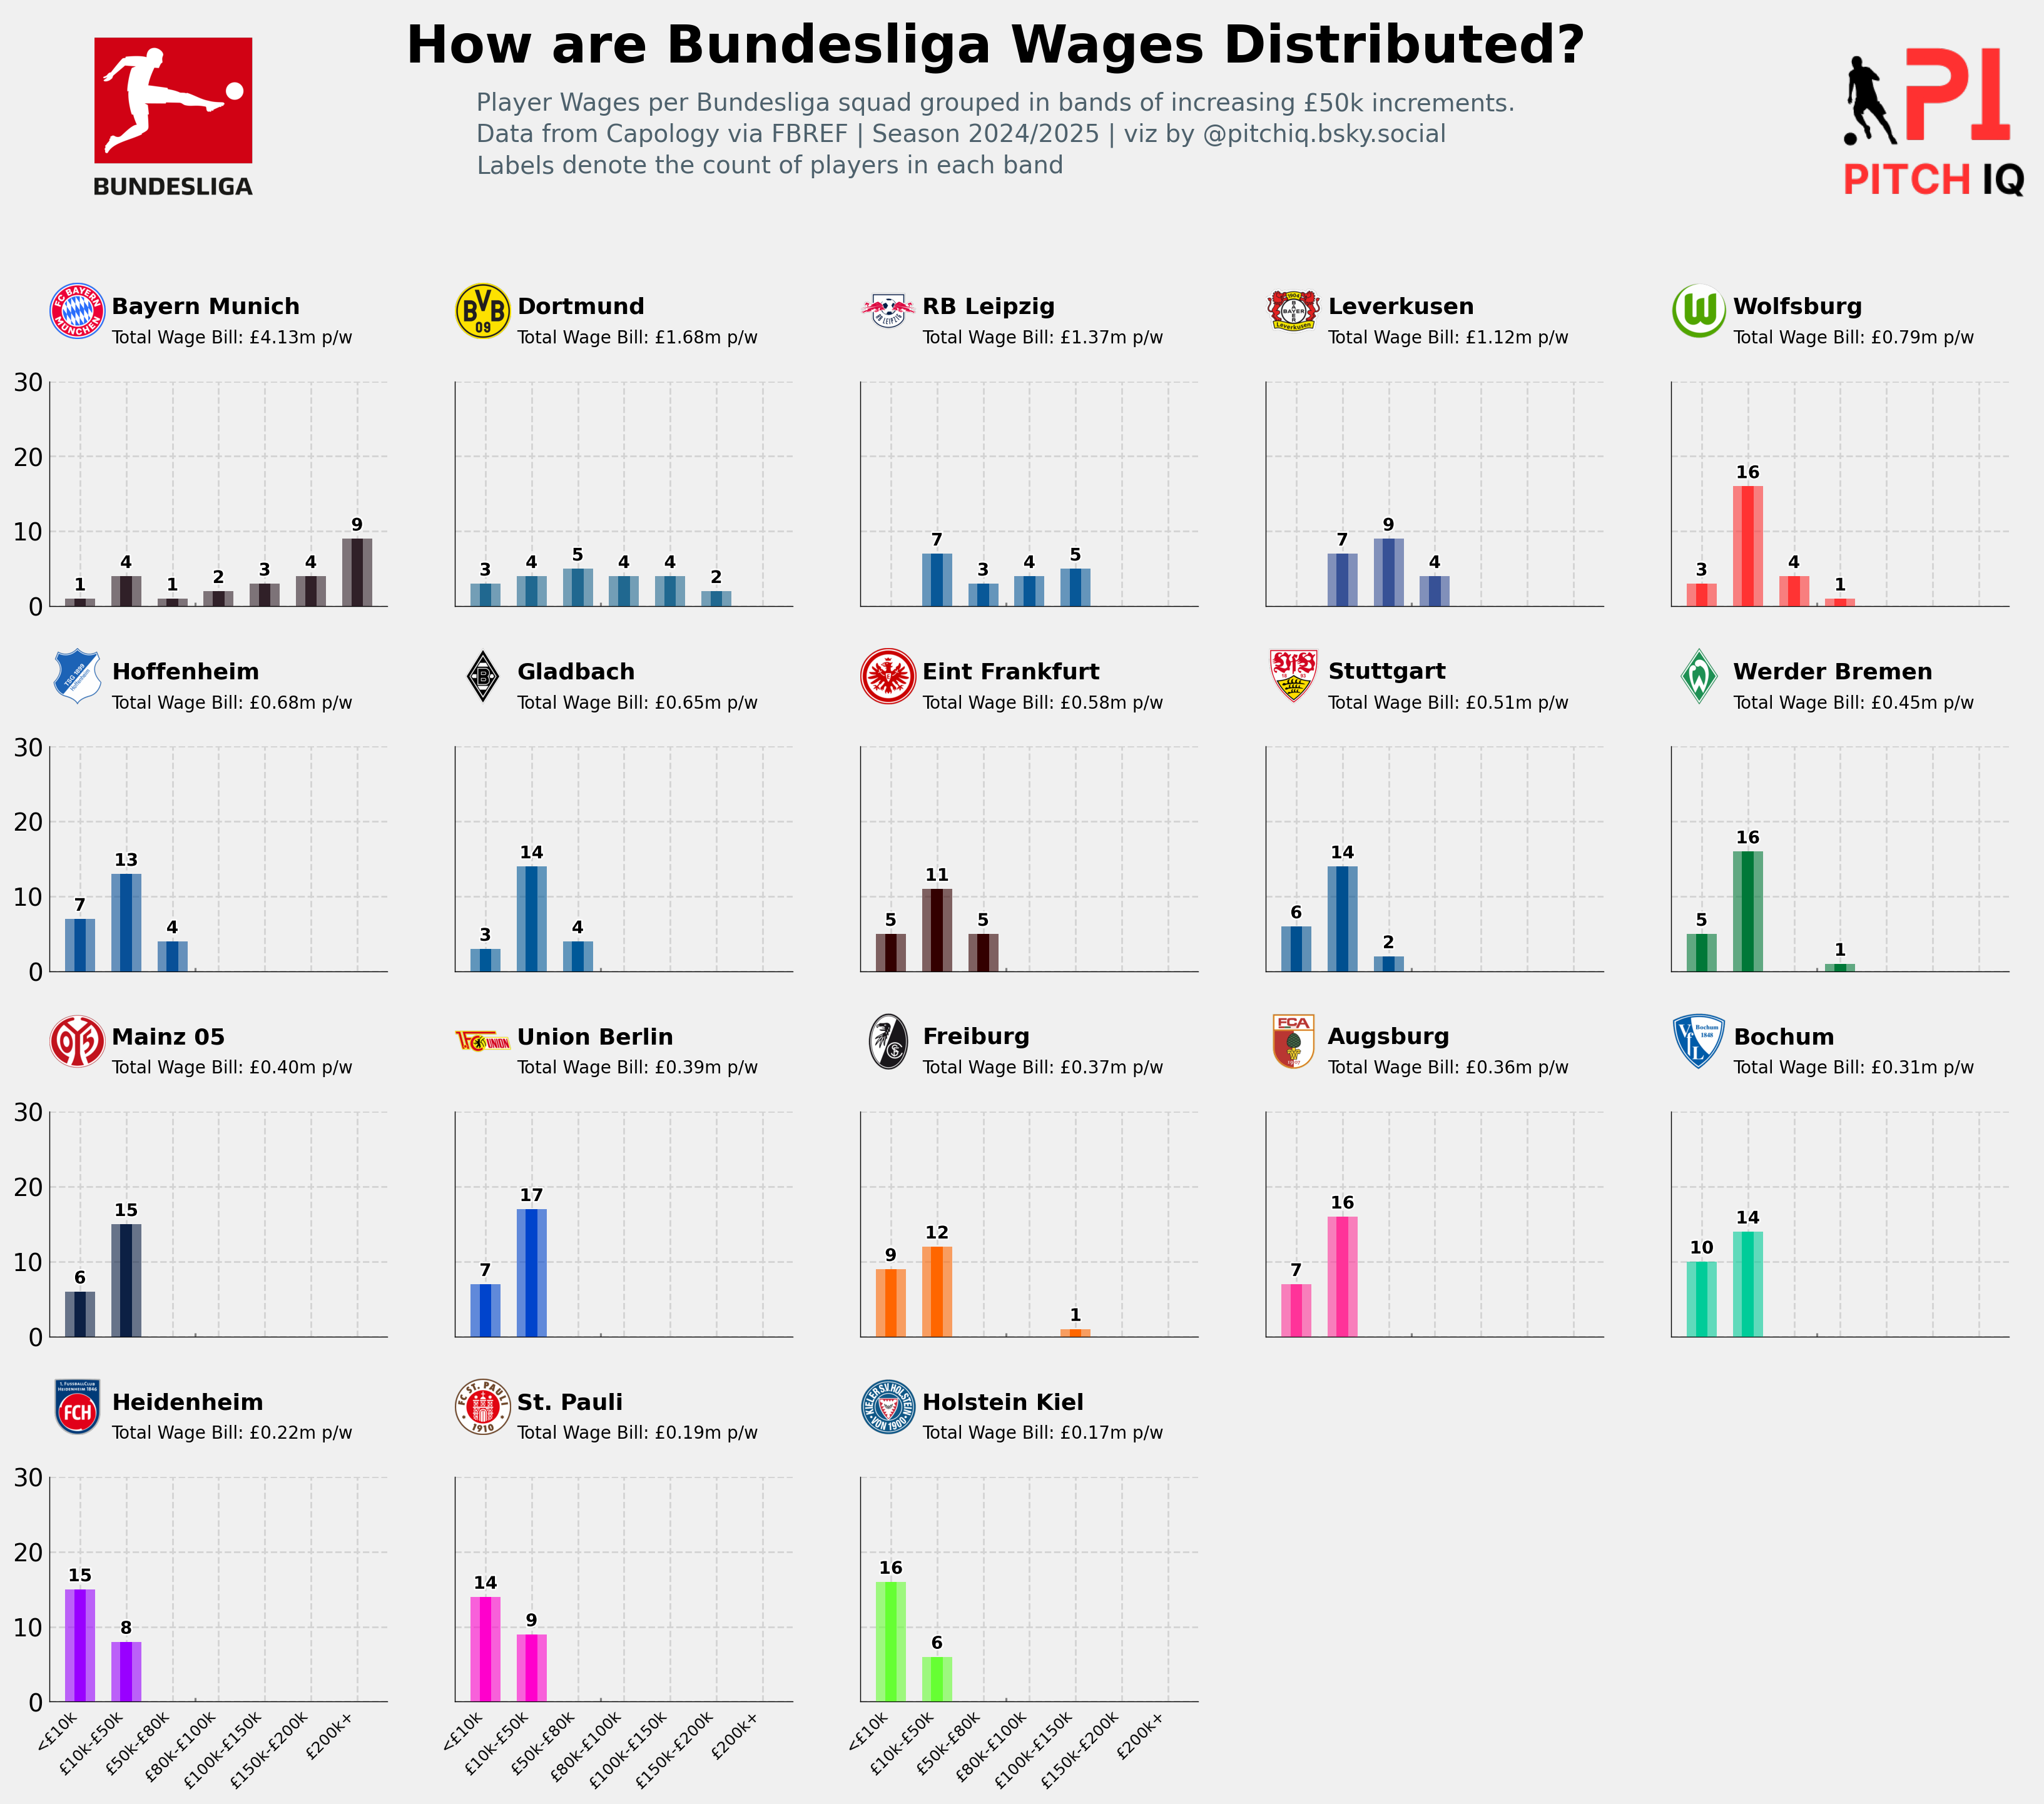

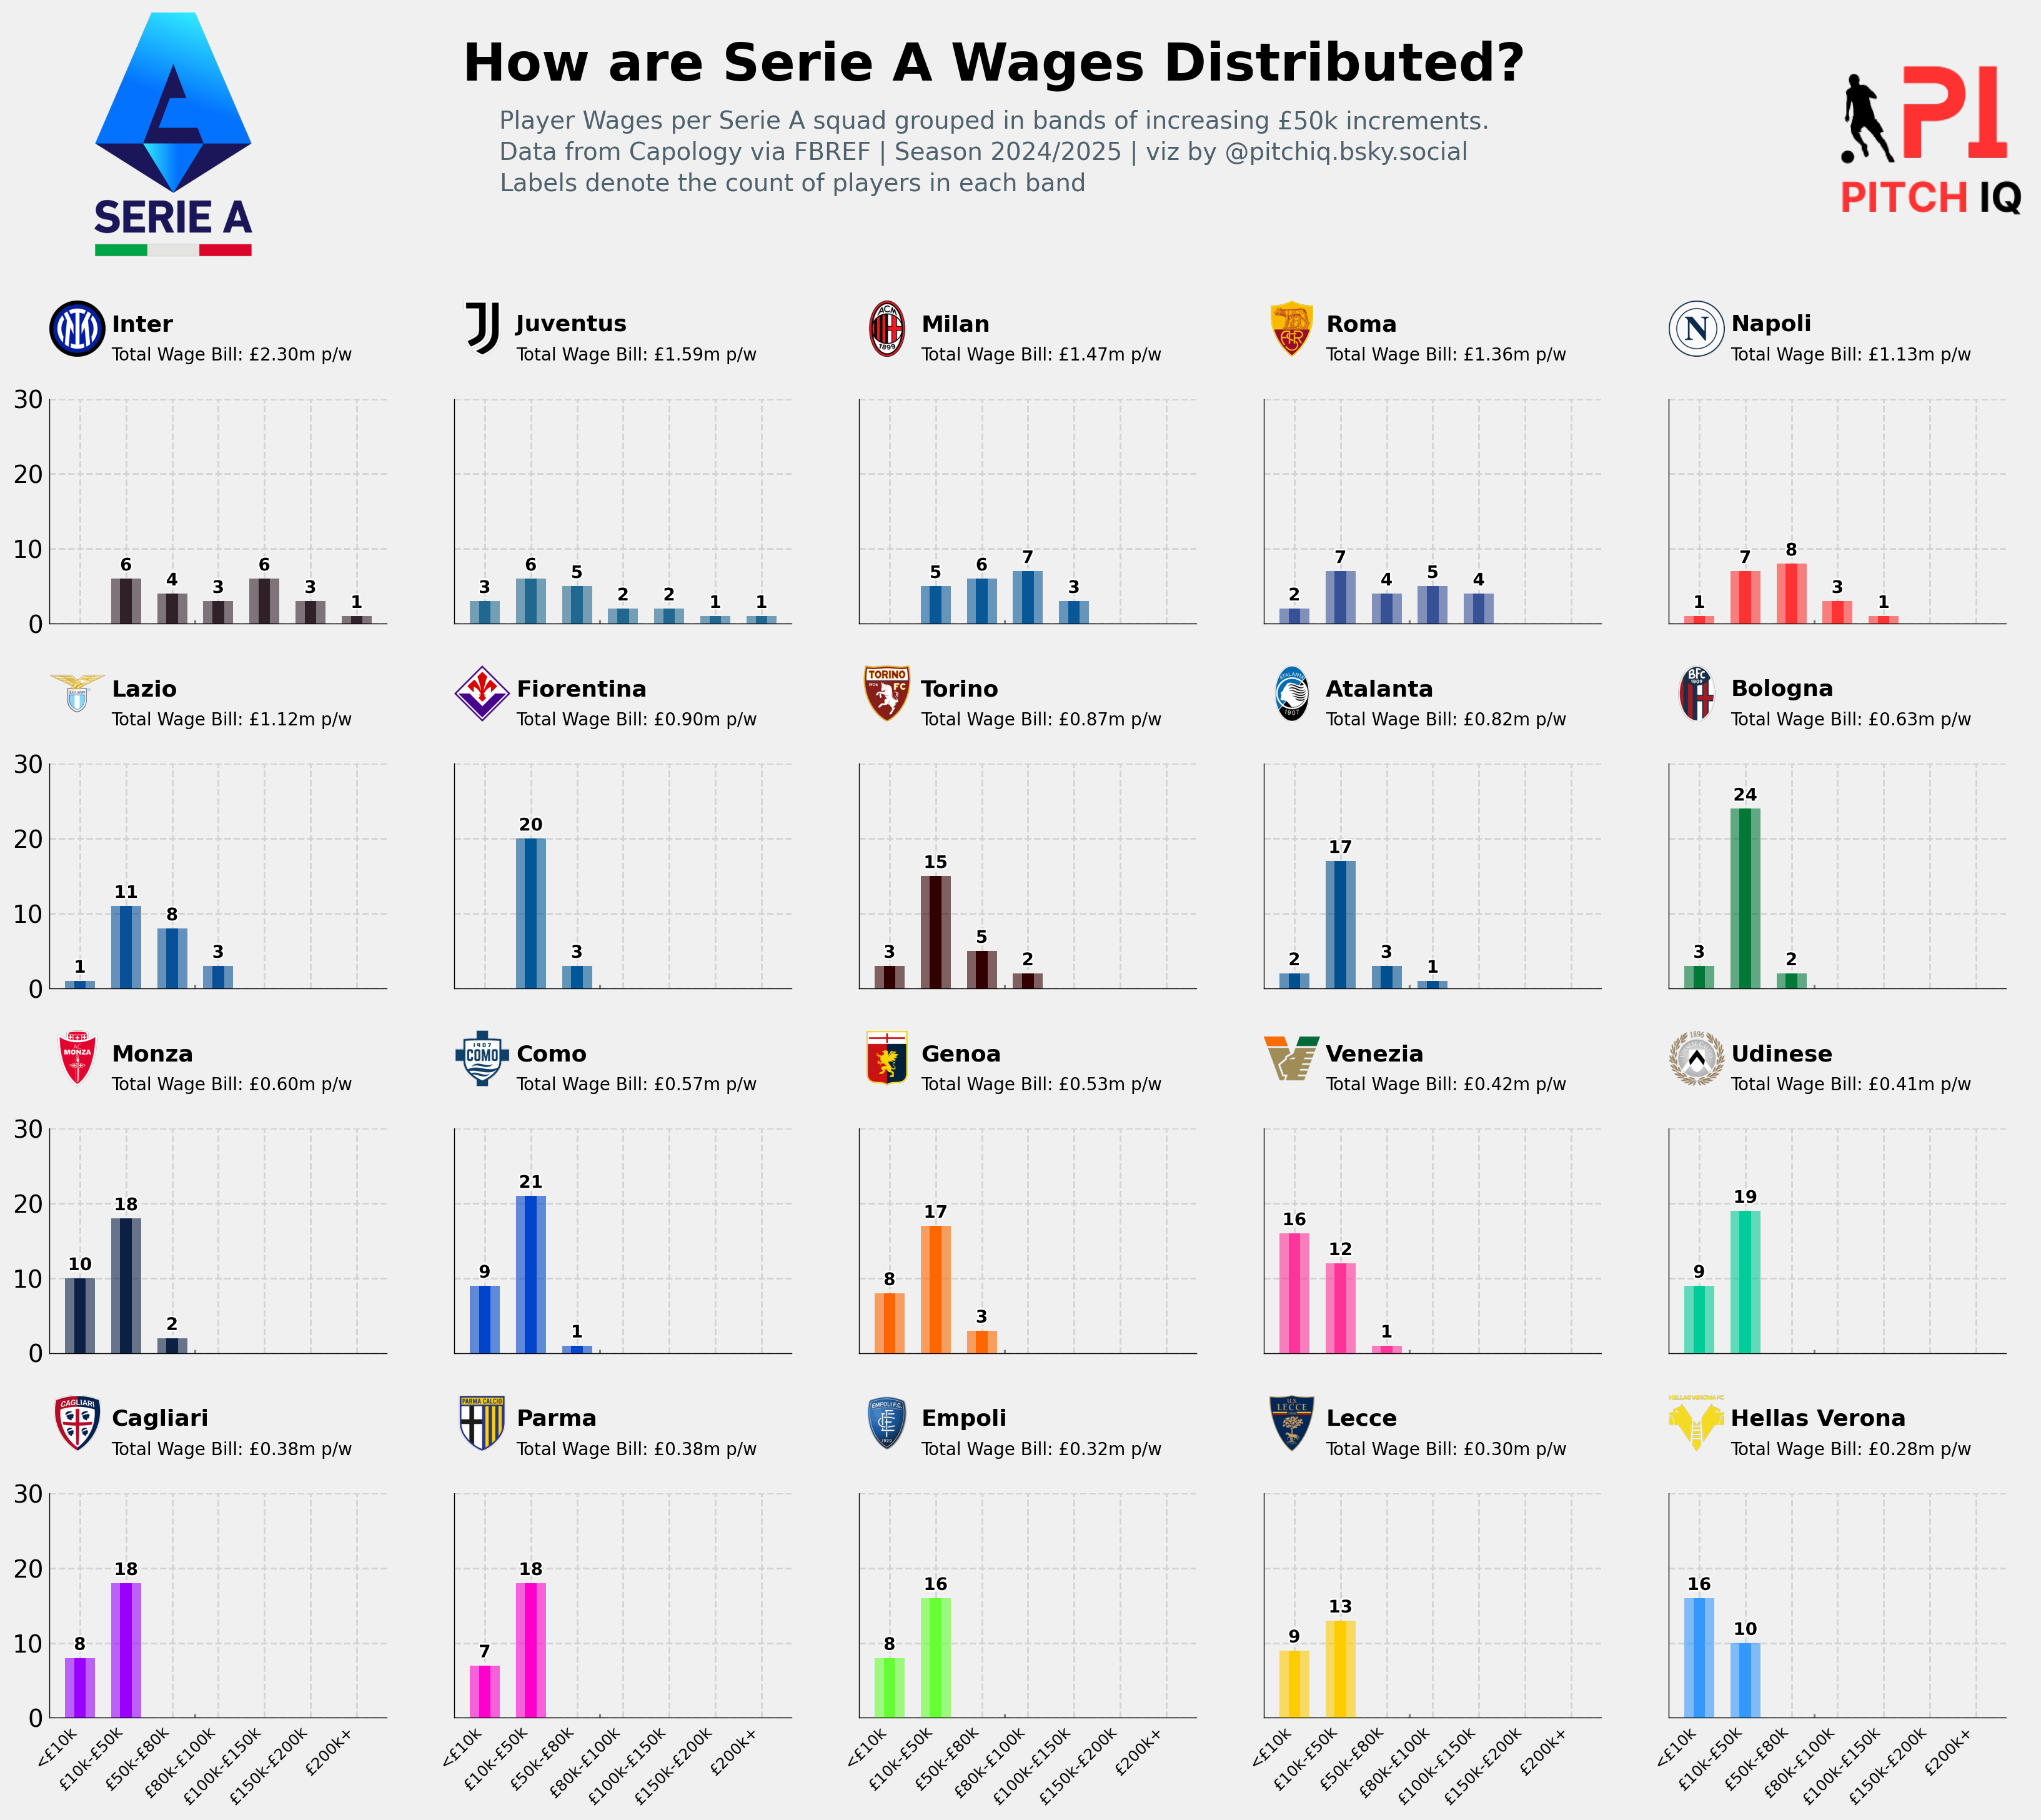

In [426]:
for league in LEAGUE_CONFIG:
    run_wage_chart_for_league(league, merged_df, team_to_league)


In [ ]:
# run_wage_chart_for_league("Serie A", merged_df, team_to_league)


In [290]:
# generate_wage_distribution_chart(
#     merged_df=merged_df,
#     csv_path="/Users/stephenahiabah/Desktop/Code/cannoniq/CSVs/Top6_leagues_fotmob_ids.csv",
#     league_name="Premier League",
#     chart_title="How are EPL Wages Distributed?",
#     league_logo_path="/Users/stephenahiabah/Desktop/Code/cannoniq/Images/premier-league-2-logo.png",
#     piq_logo_path="/Users/stephenahiabah/Desktop/Code/cannoniq/Images/piqmain.png",
#     team_to_league = team_to_league
# )

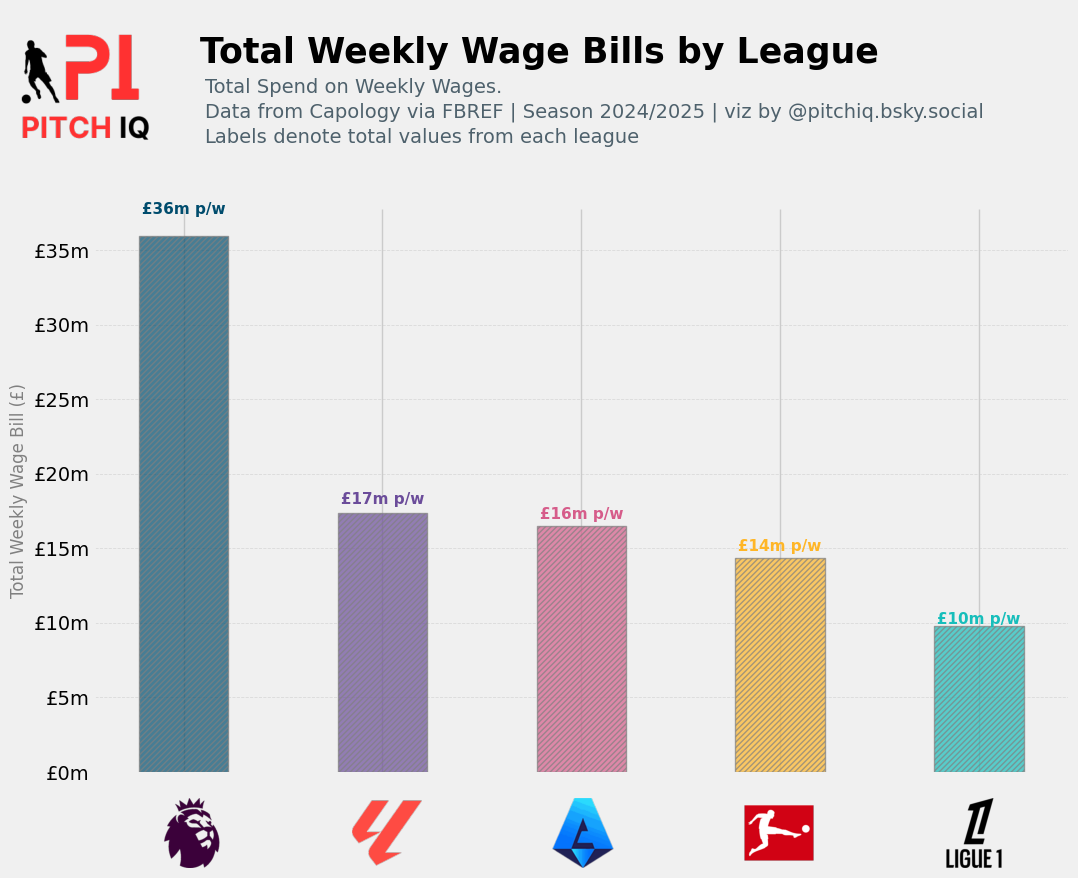

In [418]:
# STEP 1: Aggregate total wages by league
league_wage_bill = merged_df.groupby("league")["new_pound_value"].sum().sort_values(ascending=False).reset_index()

# STEP 2: League logos
logo_dir = "/Users/stephenahiabah/Desktop/Code/cannoniq/Images/"
piq_logo_path = "/Users/stephenahiabah/Desktop/Code/cannoniq/Images/piqmain.png"

league_logos = {
    "Premier League": "premier-league-2-logo.png",
    "La Liga": "LaLiga_logo.png",
    "Bundesliga": "Bundesliga_logo.png",
    "Serie A": "Serie_A_logo.png",
    "Ligue 1": "Ligue_1_2024_Logo.png"
}
# Resize logos to uniform size
resize_dim = (60, 60)
for league, filename in league_logos.items():
    path = os.path.join(logo_dir, filename)
    if os.path.exists(path):
        img = Image.open(path).convert("RGBA")
        img_resized = img.resize(resize_dim)
        img_resized.save(path)

# STEP 3: Plot
fig, ax = plt.subplots(figsize=(11, 7))
bar_colors = ['#004c6d', '#6B4C9A', '#D65C8A', '#FFB627', '#17BEBB']

bars = ax.bar(
    league_wage_bill["league"],
    league_wage_bill["new_pound_value"],
    color=bar_colors,
    hatch='//////',
    width=0.45,
    edgecolor='grey',
    alpha=0.7,
    zorder=2
)
for bar in bars:
    bar.set_linewidth(1)
    bar.set_edgecolor('grey')
    bar.set_path_effects([])
    bar.set_joinstyle('round')

# Add value labels inside each bar in £x.xmn p/w format
for i, bar in enumerate(bars):
    value = league_wage_bill["new_pound_value"].iloc[i]
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() *1.05,
        f"£{value / 1e6:.0f}m p/w",
        ha='center',
        va='center',
        fontsize=11,
        fontweight='bold',
        color=bar_colors[i]
    )

# Aesthetic cleanup
ax.set_ylabel("Total Weekly Wage Bill (£)", fontsize=12, color='grey')
ax.set_xticks(range(len(league_wage_bill)))
ax.set_xticklabels([])
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x*1e-6:.0f}m'))
ax.grid(True, axis='y', linestyle='--', linewidth=0.6, alpha=0.6, zorder=1)
ax.set_axisbelow(True)
ax.spines[['top', 'right']].set_visible(False)
ax.spines['left'].set_linewidth(0.6)
ax.spines['bottom'].set_linewidth(0.6)
ax.tick_params(axis='both', which='both', length=0)

# STEP 4 (updated): Add league logos using fig.add_axes + FotMob URLs
league_id_map = {
    "Premier League": 47,
    "Bundesliga": 54,
    "Serie A": 55,
    "La Liga": 87,
    "Ligue 1": 53,
}

for i, league in enumerate(league_wage_bill["league"]):
    league_id = league_id_map.get(league)
    if not league_id:
        continue

    try:
        logo_url = f"https://images.fotmob.com/image_resources/logo/leaguelogo/{league_id}.png"
        response = urllib.request.urlopen(logo_url)
        logo_img = Image.open(BytesIO(response.read()))

        bar = bars[i]
        x_pos = bar.get_x() + bar.get_width() / 2
        y_pos = -0.5e6  # Adjust this based on your y-axis range

        ax_coords = ax.transData.transform((x_pos, y_pos))
        fig_coords = fig.transFigure.inverted().transform(ax_coords)

        ax_logo = fig.add_axes([
            fig_coords[0] - 0.025,  # previously -0.015, this pushes it slightly right
            fig_coords[1] - 0.15,   # lowers the logo slightly
            0.1,                   # increase width (was 0.03)
            0.1                    # increase height (was 0.03)
        ])
        ax_logo.imshow(logo_img)
        ax_logo.axis('off')

    except Exception as e:
        print(f"Error loading logo for {league}: {e}")

# STEP 5: Titles

fig_text(x=0.5, y=1.05, s="Total Weekly Wage Bills by League", va="bottom", ha="center", fontsize=25, color="black", weight="bold")
fig_text(
    x=0.55, y=0.94,
    s=f"Total Spend on Weekly Wages.\nData from Capology via FBREF | Season 2024/2025 | viz by @pitchiq.bsky.social\n<Labels> denote total values from each league",
    va="bottom", ha="center", fontsize=14, color="#4E616C"
)

# STEP 6: Add PIQ branding logo
ax3 = fig.add_axes([0.02, 0.58, 0.13, 0.9])
ax3.axis('off')
ax3.imshow(image.imread(piq_logo_path))

# Final polish
plt.tight_layout()
plt.subplots_adjust(top=0.85)

output_dir = "/Users/stephenahiabah/Desktop/Code/cannoniq/Financial Analysis/Wage Charts/"
os.makedirs(output_dir, exist_ok=True)

plt.savefig(f"{output_dir}Total_Weekly_Wage_Bills_by_League.png", bbox_inches='tight', dpi=400)
plt.show()


In [438]:
team_to_league

{'Arsenal': 'Premier League',
 'Aston Villa': 'Premier League',
 'Bournemouth': 'Premier League',
 'Brentford': 'Premier League',
 'Brighton': 'Premier League',
 'Chelsea': 'Premier League',
 'Crystal Palace': 'Premier League',
 'Everton': 'Premier League',
 'Fulham': 'Premier League',
 'Ipswich Town': 'Premier League',
 'Leicester City': 'Premier League',
 'Liverpool': 'Premier League',
 'Manchester City': 'Premier League',
 'Manchester Utd': 'Premier League',
 "Nott'ham Forest": 'Premier League',
 'Newcastle Utd': 'Premier League',
 'Southampton': 'Premier League',
 'Tottenham': 'Premier League',
 'West Ham': 'Premier League',
 'Wolves': 'Premier League',
 'Alavés': 'La Liga',
 'Athletic Club': 'La Liga',
 'Atlético Madrid': 'La Liga',
 'Barcelona': 'La Liga',
 'Celta Vigo': 'La Liga',
 'Espanyol': 'La Liga',
 'Getafe': 'La Liga',
 'Girona': 'La Liga',
 'Las Palmas': 'La Liga',
 'Leganés': 'La Liga',
 'Mallorca': 'La Liga',
 'Osasuna': 'La Liga',
 'Rayo Vallecano': 'La Liga',
 'Real 

In [636]:
def generate_league_data(url_list,team_to_league,merged_df):
    all_data = []
    
    features_wanted = {
        "team", "games", "wins", "draws", "losses",
        "goals_for", "goals_against", "points",
        "xg_for", "xg_against", "xg_diff", "attendance",
        "xg_diff_per90", "last_5"
    }

    for url in url_list:
        page = urlopen(url).read()
        soup = BeautifulSoup(page, 'html.parser')
        table = soup.find("tbody")
        
        league_name = url.split("/")[-1].replace("-", " ").replace(" Stats", "").strip()  # extract e.g. "Premier-League-Stats"

        pre_df = dict()
        rows = table.find_all('tr')
        for row in rows:
            for f in features_wanted:
                if (row.find('th', {"scope": "row"}) is not None) and (row.find("td", {"data-stat": f}) is not None):
                    cell = row.find("td", {"data-stat": f})
                    text = cell.text.strip()
                    if f in pre_df:
                        pre_df[f].append(text)
                    else:
                        pre_df[f] = [text]

        df = pd.DataFrame.from_dict(pre_df)
        df["league"] = league_name
        df["games"] = pd.to_numeric(df["games"], errors='coerce')
        df["xg_diff_per90"] = pd.to_numeric(df["xg_diff_per90"], errors='coerce')
        df["minutes_played"] = df["games"] * 90
        all_data.append(df)

    combined_df = pd.concat(all_data, ignore_index=True)

    combined_df['goals_for'] = pd. to_numeric(combined_df['goals_for'])
    combined_df['goals_against'] = pd.to_numeric(combined_df['goals_against'])

    combined_df["goal_diff"] = combined_df["goals_for"] - combined_df["goals_against"]

    # Then compute rank: sort by points (descending), then by goal difference (descending)
    combined_df["league_rank"] = (
        combined_df
        .sort_values(by=["league", "points", "goal_diff"], ascending=[True, False, False])
        .groupby("league")
        .cumcount() + 1
    )
    league_ranked_wage = (
        merged_df.groupby(["league", "Squad"])["new_pound_value"]
        .sum()
        .reset_index()
        .sort_values(by=["league", "new_pound_value"], ascending=[True, False])
    )
    league_ranked_wage["wage_rank"] = (
        league_ranked_wage.groupby("league")["new_pound_value"]
        .rank(ascending=False, method="first")
        .astype(int)
    )

    csv_path = "/Users/stephenahiabah/Desktop/Code/cannoniq/CSVs/Top6_leagues_fotmob_ids.csv"
    df_league_table_renamed = combined_df.rename(columns={"team": "Squad"})

    # Perform left join on 'Squad'
    df_combined = df_league_table_renamed.merge(
        league_ranked_wage,
        how="left",
        on=["Squad", "league"]
    )
    fm_ids = pd.read_csv(csv_path)[["team", "team_id"]].rename(columns={"team": "Squad"})
    df_combined = df_combined.merge(fm_ids, on='Squad', how='left')




    return df_combined

In [637]:
df_league_table = generate_league_data(leagues,team_to_league,merged_df)

df_league_table

Squad points  games xg_for  xg_diff_per90 xg_against wins  \
0         Liverpool     84     38   82.2           1.15       38.6   25   
1           Arsenal     74     38   59.9           0.67       34.4   20   
2   Manchester City     71     38   68.1           0.54       47.7   21   
3           Chelsea     69     38   67.8           0.54       47.3   20   
4     Newcastle Utd     66     38   63.8           0.48       45.5   20   
5       Aston Villa     66     38   56.1           0.16       50.1   19   
6   Nott'ham Forest     65     38   45.5          -0.09       48.9   19   
7          Brighton     61     38   58.7           0.11       54.6   16   
8       Bournemouth     56     38   64.0           0.41       48.5   15   
9         Brentford     56     38   59.0           0.09       55.4   16   
10           Fulham     54     38   49.0           0.05       47.2   15   
11   Crystal Palace     53     38   60.4           0.30       49.1   13   
12          Everton     48     38   41.8          -0.12       46.2   11   
13         West Ham     43     38   47.0          -0.33       59.7   11   
14   Manchester Utd     42     38   52.6          -0.03       53.8   11   
15           Wolves     42     38   43.7          -0.38       58.1   12   
16        Tottenham     38     38   58.8          -0.12       63.3   11   
17   Leicester City     25     38   32.6          -1.03       71.9    6   
18     Ipswich Town     22     38   34.4          -1.01       72.7    4   
19      Southampton     12     38   32.7          -1.37       84.8    2   
20        Barcelona     88     38   91.5           1.30       41.9   28   
21      Real Madrid     84     38   75.3           0.86       42.8   26   
22  Atlético Madrid     76     38   64.6           0.82       33.4   22   
23    Athletic Club     70     38   53.0           0.40       37.8   19   
24       Villarreal     70     38   64.8           0.54       44.4   20   
25            Betis     60     38   54.7           0.11       50.6   16   
26       Celta Vigo     55     38   54.2           0.29       43.4   16   
27   Rayo Vallecano     52     38   45.4          -0.09       49.0   13   
28          Osasuna     52     38   44.0          -0.25       53.7   12   
29         Mallorca     48     38   38.8          -0.21       46.8   13   
30    Real Sociedad     46     38   42.5          -0.04       43.9   13   
31         Valencia     46     38   43.2          -0.23       51.9   11   
32           Getafe     42     38   36.8          -0.25       46.2   11   
33         Espanyol     42     38   34.4          -0.51       53.8   11   
34           Alavés     42     38   42.8          -0.11       47.0   10   
35           Girona     41     38   42.5          -0.21       50.4   11   
36          Sevilla     41     38   42.7          -0.12       47.4   10   
37          Leganés     40     38   36.0          -0.62       59.4    9   
38       Las Palmas     32     38   36.3          -0.80       66.8    8   
39       Valladolid     16     38   34.6          -0.87       67.6    4   
40    Bayern Munich     82     34   81.7           1.65       25.5   25   
41       Leverkusen     69     34   56.9           0.61       36.2   19   
42   Eint Frankfurt     60     34   65.1           0.50       48.0   17   
43         Dortmund     57     34   61.2           0.54       42.8   17   
44         Freiburg     55     34   44.3           0.05       42.4   16   
45         Mainz 05     52     34   50.1           0.06       48.1   14   
46       RB Leipzig     51     34   46.6          -0.20       53.3   13   
47    Werder Bremen     51     34   49.1           0.03       48.1   14   
48        Stuttgart     50     34   62.3           0.45       46.9   14   
49         Gladbach     45     34   50.6          -0.37       63.4   13   
50        Wolfsburg     43     34   47.5          -0.15       52.5   11   
51         Augsburg     43     34   34.7          -0.42       48.9   11   
52     Union Berlin     40     34   37.

In [465]:
df_pl = df_combined[df_combined['league'] == 'Premier League'].copy()


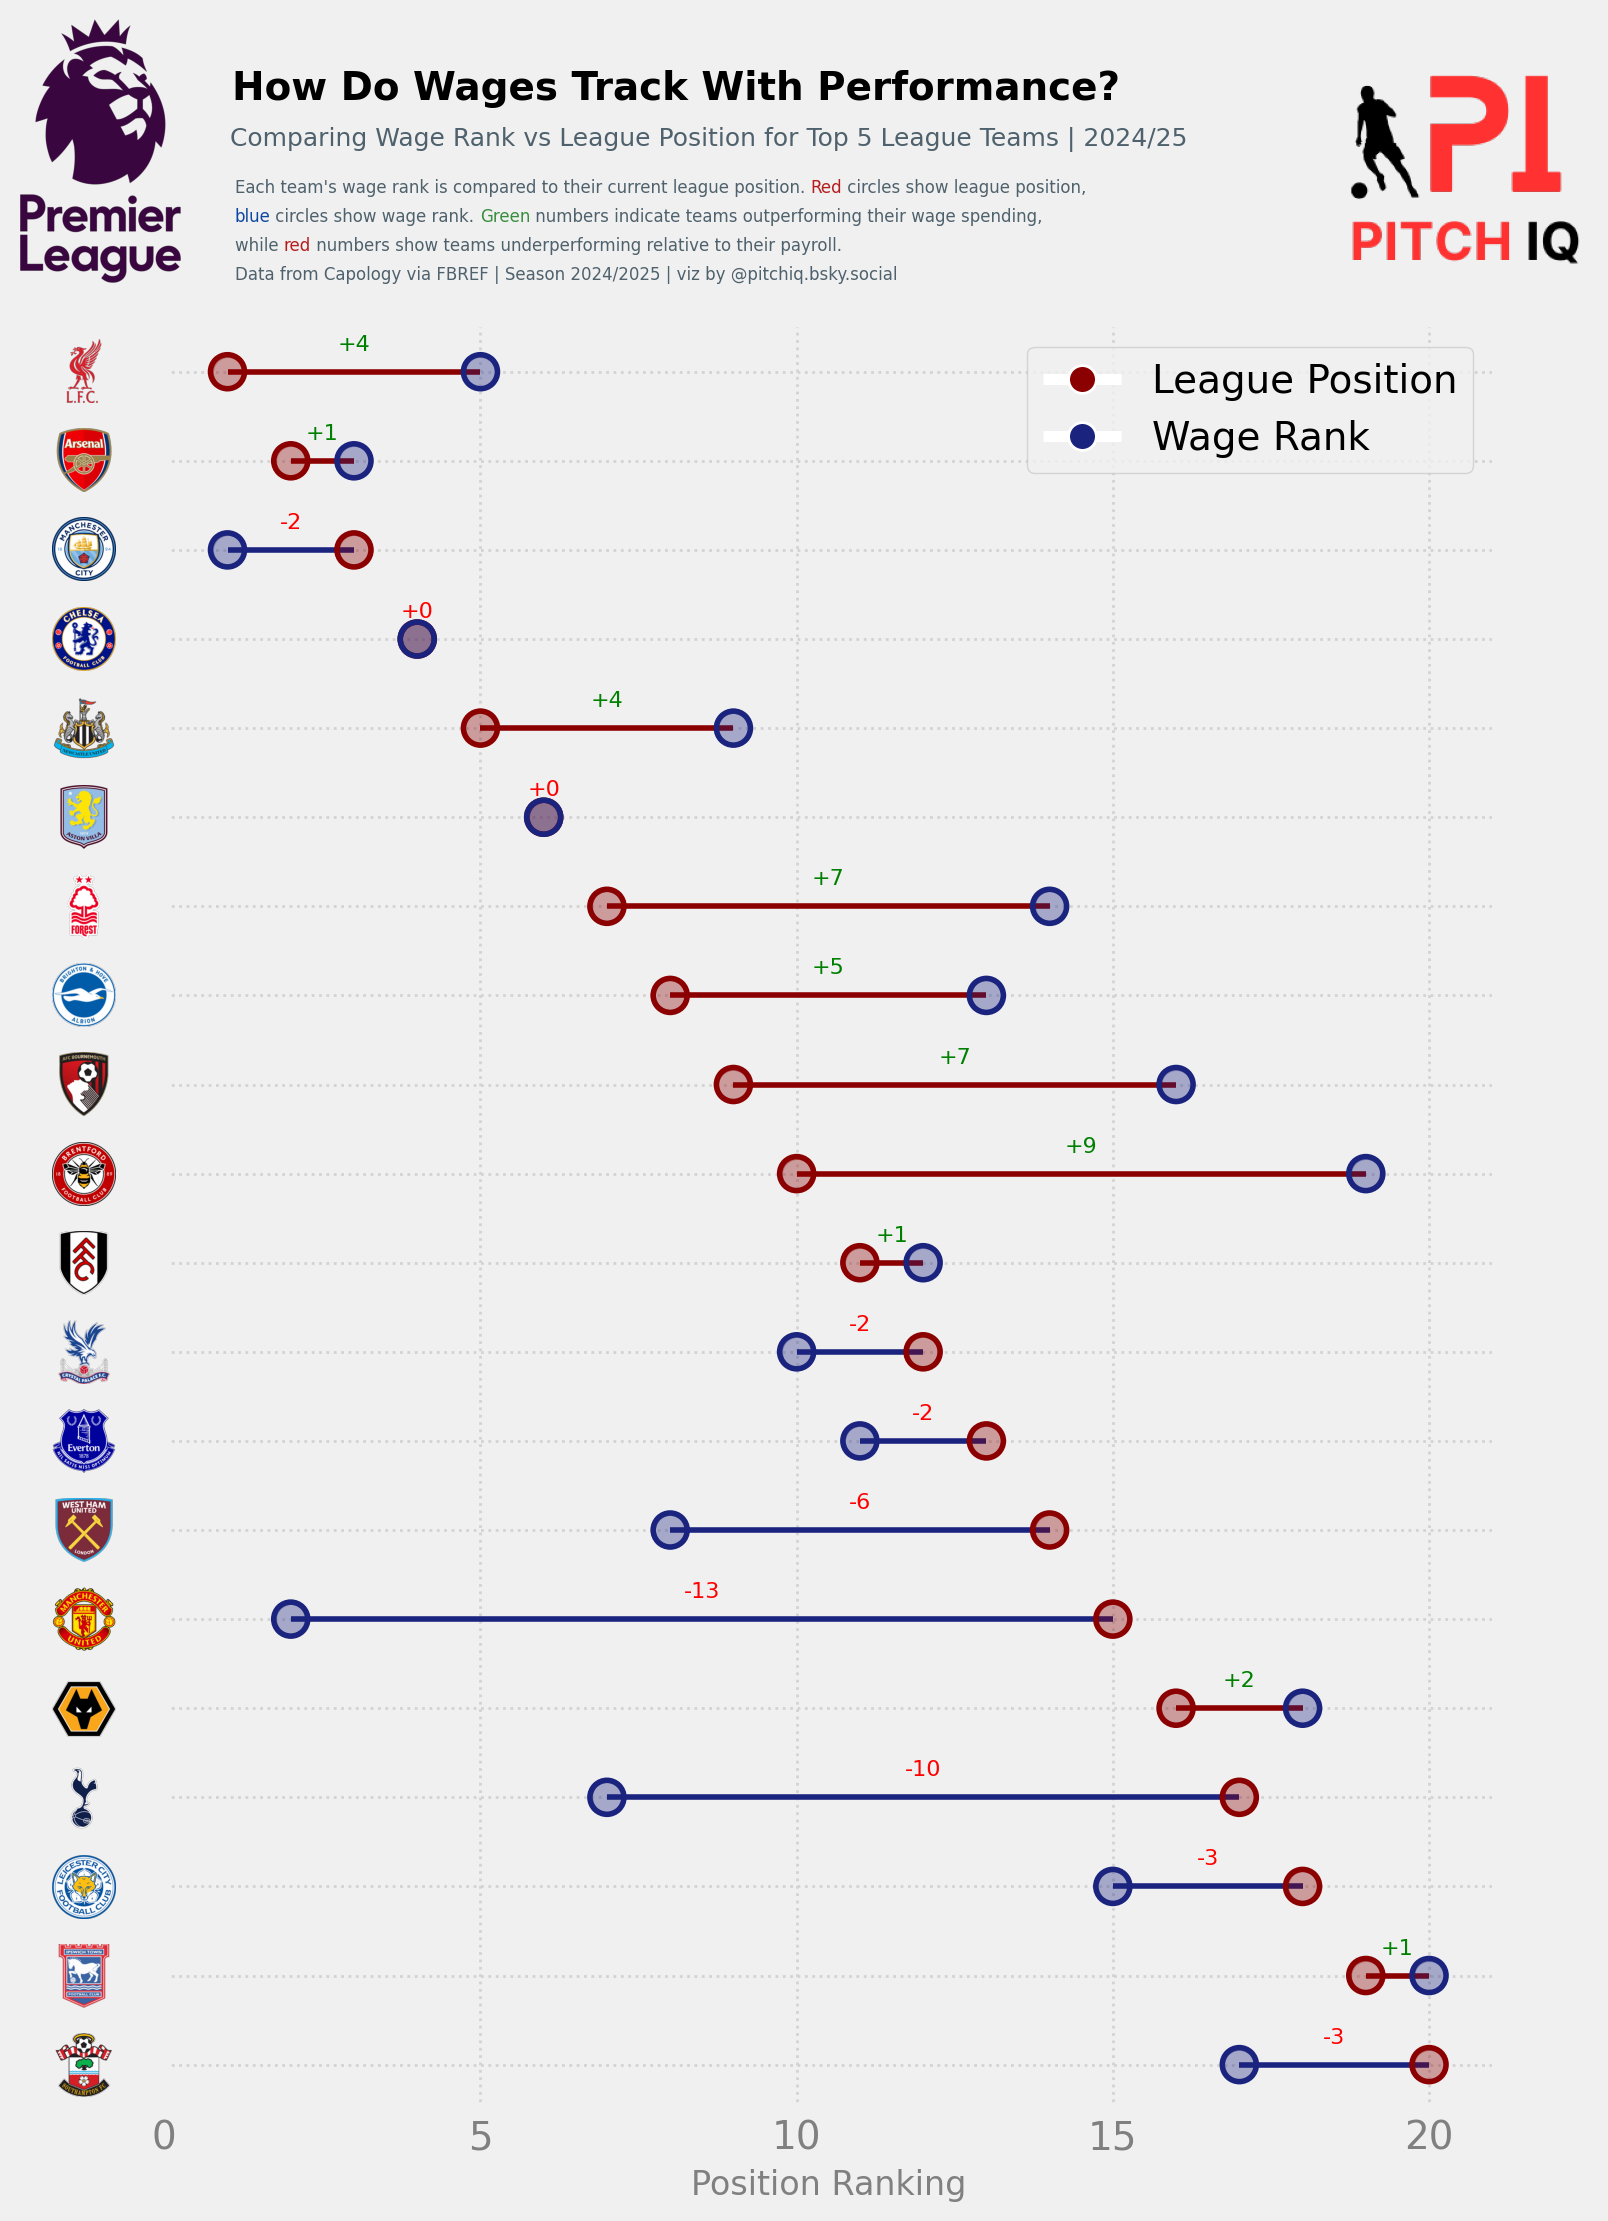

In [631]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from io import BytesIO
import urllib
from PIL import Image
from highlight_text import fig_text
import numpy as np

plt.style.use('fivethirtyeight')

# Prepare data
df_pl['league_rank'] = pd.to_numeric(df_pl['league_rank'], errors='coerce')
df_pl['wage_rank'] = pd.to_numeric(df_pl['wage_rank'], errors='coerce')
df_sorted = df_pl.sort_values(by=['league', 'league_rank'], ascending=False).reset_index(drop=True)

# Plot setup
fig = plt.figure(figsize=(8, 11), dpi=200)  # Made slightly wider for logos
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True, color="lightgrey", ls=":")

# Axes & points
Y = np.arange(len(df_sorted))
league_ranks = df_sorted["league_rank"]
wage_ranks = df_sorted["wage_rank"]

ax.set_ylim(-0.5, len(df_sorted) - 0.5)
ax.set_xlim(
    min(min(league_ranks), min(wage_ranks)) - 1,
    max(max(league_ranks), max(wage_ranks)) + 1
)

ax.scatter(league_ranks, Y, color="#8b0000", s=120, alpha=0.35, zorder=3)
ax.scatter(wage_ranks, Y, color="#1a237e", s=120, alpha=0.35, zorder=3)
ax.scatter(league_ranks, Y, facecolors='none', edgecolors="#8b0000", s=150, lw=2, zorder=3)
ax.scatter(wage_ranks, Y, facecolors='none', edgecolors="#1a237e", s=150, lw=2, zorder=3)

from matplotlib.patches import Patch
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#8b0000', markersize=10, label='League Position'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#1a237e', markersize=10, label='Wage Rank')
]
ax.legend(handles=legend_elements, loc='upper right')

# Delta labels
for idx, y_val in enumerate(Y):
    x1 = league_ranks.iloc[idx]
    x2 = wage_ranks.iloc[idx]
    delta = x2 - x1
    mid_x = (x1 + x2) / 2
    color = 'green' if delta > 0 else 'red'
    ax.text(mid_x, y_val + 0.2, f'{delta:+.0f}', ha='center', va='bottom', fontsize=8, color=color) 

for idx, y_val in enumerate(Y):
    x1 = league_ranks.iloc[idx]
    x2 = wage_ranks.iloc[idx]
    color = "#1a237e" if x2 < x1 else "#8b0000"
    ax.plot([x1, x2], [y_val, y_val], lw=2, color=color, zorder=2)

# This is the key part - position logos where y-labels should be
# Calculate the plot area bounds
plot_bottom = 0.08  # bottom of plot area in figure coordinates
plot_top = 0.85     # top of plot area in figure coordinates
plot_height = plot_top - plot_bottom

for idx, team_id in enumerate(df_sorted["team_id"]):
    try:
        y_pos = idx
        total_teams = len(df_sorted)
        
        # Calculate position as fraction of plot height, then convert to figure coordinates
        # Reverse the order since matplotlib y=0 is at bottom but we want first team at top
        y_fraction = y_pos / (total_teams - 1) if total_teams > 1 else 0.5
        y_fig_coord = plot_bottom + (y_fraction * plot_height) + 0.01  # Adjusted to fit logos nicely
        
        # Create a small axes for each logo positioned at the y-tick location
        logo_ax = fig.add_axes([0.05, y_fig_coord - 0.02, 0.04, 0.04])
        
        url = f"https://images.fotmob.com/image_resources/logo/teamlogo/{int(team_id)}.png"
        club_icon = Image.open(urllib.request.urlopen(url))
        logo_ax.imshow(club_icon)
        logo_ax.axis("off")
        
    except Exception as e:
        print(f"Logo error for team_id {team_id}: {e}")

# Set ticks but no labels since we're using logos
ax.set_yticks(np.arange(len(df_sorted)))
ax.set_yticklabels([])
ax.set_xticks(range(0, 21, 5))
ax.set_xticklabels(range(0, 21, 5), color='grey')
ax.set_xlabel("Position Ranking", fontsize=12, color='grey')

# Adjust the main plot to make room for logos
plt.subplots_adjust(left=0.12)

fig_text(
    x=0.44, y=0.98,
    s="How Do Wages Track With Performance?",
    va="bottom", ha="center",
    fontsize=14, color="black", weight="bold"
)
fig_text(
    x=0.46, y=0.96,
    s="Comparing Wage Rank vs League Position for Top 5 League Teams | 2024/25",
    va="bottom", ha="center",
    fontsize=9, color="#4E616C"
)
fig_text(
    x=0.43, y=0.9,
    s="Each team's wage rank is compared to their current league position. <Red> circles show league position,\n<blue> circles show wage rank. <Green> numbers indicate teams outperforming their wage spending,\nwhile <red> numbers show teams underperforming relative to their payroll.\nData from Capology via FBREF | Season 2024/2025 | viz by @pitchiq.bsky.social",
    va="bottom", ha="center", fontsize=6, color="#4E616C",
    highlight_textprops=[{"color": "#b71c1c"},  {"color": "#0d47a1"},  {"color": "#388e3c"}, {"color": "#b71c1c"}]
)

league_icon = Image.open("/Users/stephenahiabah/Desktop/Code/cannoniq/Images/premier-league-2-logo.png")
league_ax = fig.add_axes([0.02, 0.90, 0.12, 0.12], zorder=1)
league_ax.imshow(league_icon)
league_ax.axis("off")


### Add Stats by Steve logo
ax3 = fig.add_axes([0.85, 0.155, 0.16, 1.60])
ax3.axis('off')
img = plt.imread('/Users/stephenahiabah/Desktop/Code/cannoniq/Images/piqmain.png')
ax3.imshow(img)

output_dir = "/Users/stephenahiabah/Desktop/Code/cannoniq/Financial Analysis/Wage Charts/"
os.makedirs(output_dir, exist_ok=True)

plt.savefig(f"{output_dir}Wages_League_Correlation.png", bbox_inches='tight', dpi=400)

plt.show()

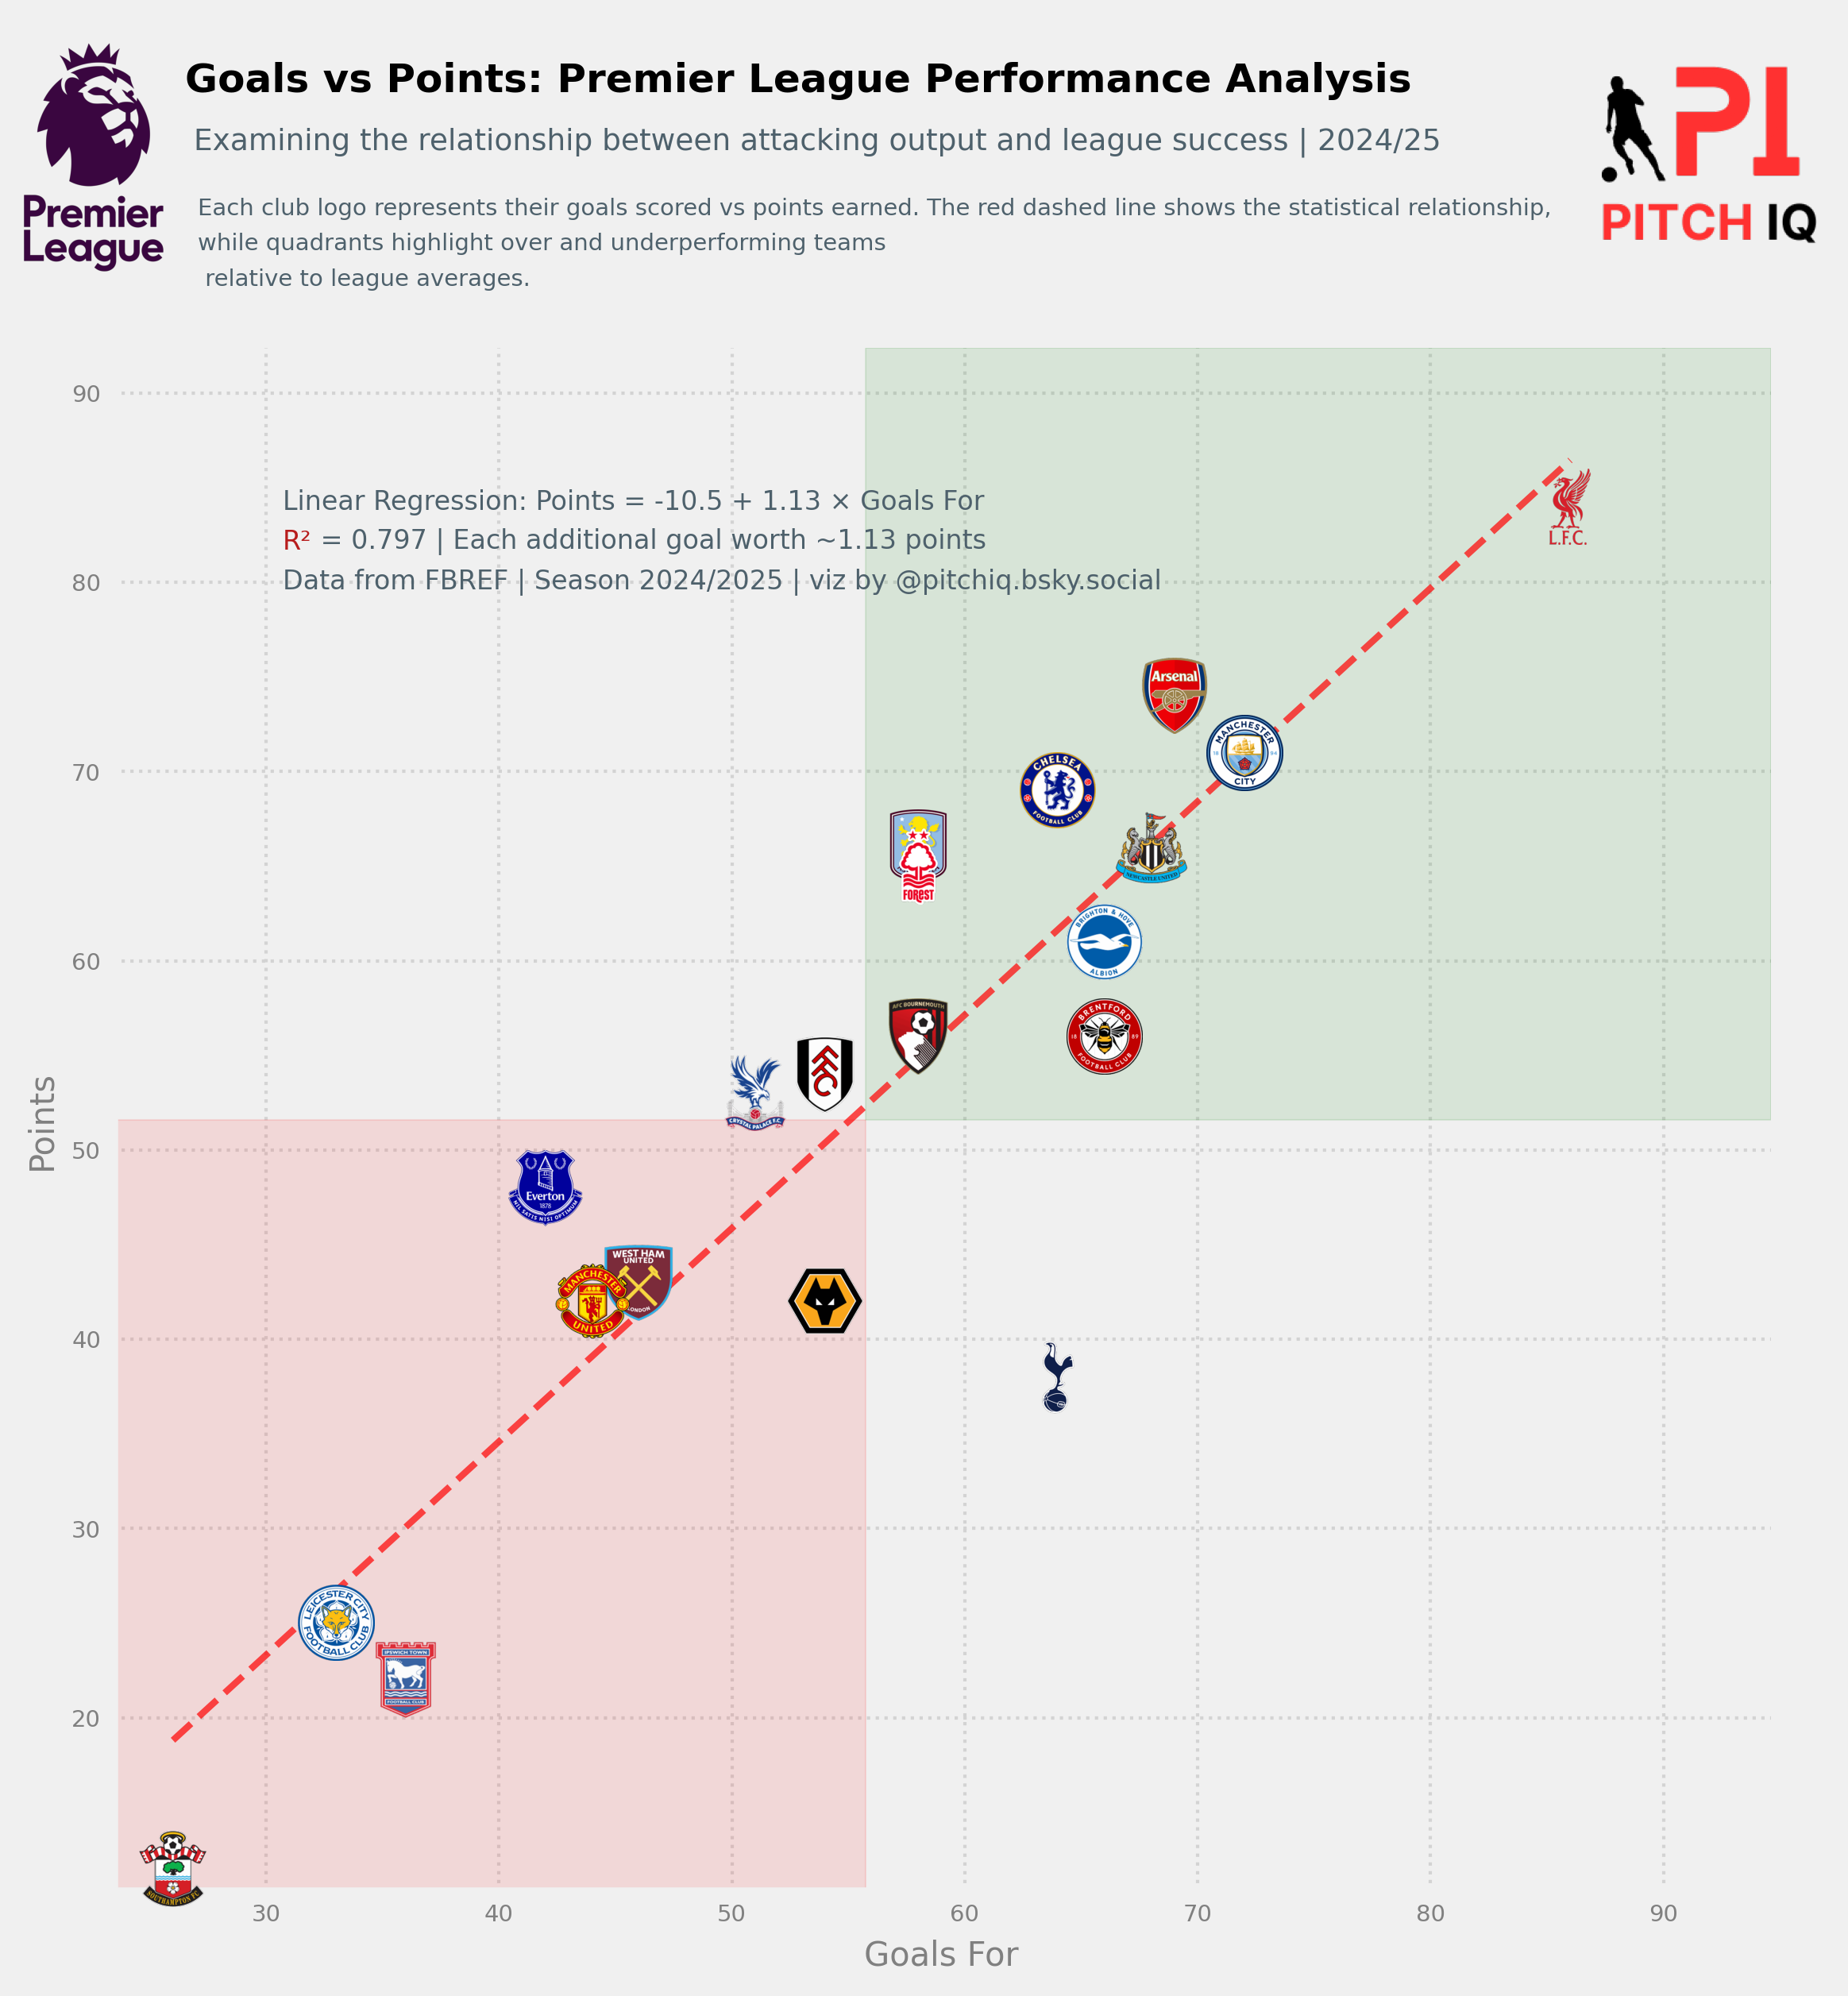


=== LINEAR REGRESSION RESULTS ===
Equation: Points = -10.51 + 1.128 × Goals For
R-squared: 0.7968
Correlation strength: Strong
Each additional goal is worth approximately 1.13 points

=== EXAMPLE PREDICTIONS ===
Team scoring 30 goals → Predicted points: 23.3
Team scoring 50 goals → Predicted points: 45.9
Team scoring 70 goals → Predicted points: 68.4
Team scoring 90 goals → Predicted points: 91.0


In [657]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import urllib.request
from highlight_text import fig_text
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import os

plt.style.use('fivethirtyeight')

# Filter for Premier League only
df_pl_filtered = df_pl[df_pl['league'] == 'Premier League'].copy()

# Convert to numeric and prepare variables
df_pl_filtered['points'] = pd.to_numeric(df_pl_filtered['points'], errors='coerce')
df_pl_filtered['goals_for'] = pd.to_numeric(df_pl_filtered['goals_for'], errors='coerce')

x_loc = df_pl_filtered["goals_for"]
y_loc = df_pl_filtered['points']
# Create figure
fig = plt.figure(figsize=(8, 8), dpi=300)
ax = plt.subplot()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True, color="lightgrey", ls=":")

# Set limits with padding
ax.set_xlim(x_loc.min() * 0.9, x_loc.max() * 1.1)
ax.set_ylim(y_loc.min() * 0.9, y_loc.max() * 1.1)

# Transformation functions for logo positioning
DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))

ax_size = 0.04

# Add club logos at data points
for idx, (x, y) in enumerate(zip(x_loc, y_loc)):
    team_id = df_pl_filtered.iloc[idx]['team_id']
    ax_coords = DC_to_NFC((x, y))
    
    try:
        image_ax = fig.add_axes(
            [ax_coords[0] - ax_size/2, ax_coords[1] - ax_size/2, ax_size, ax_size],
            fc='None'
        )
        
        url = f"https://images.fotmob.com/image_resources/logo/teamlogo/{int(team_id)}.png"
        club_icon = Image.open(urllib.request.urlopen(url))
        image_ax.imshow(club_icon)
        image_ax.axis("off")
    except Exception as e:
        print(f"Logo error for team_id {team_id}: {e}")

# Linear regression
X = x_loc.values.reshape(-1, 1)
y = y_loc.values
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Calculate R-squared
r2 = r2_score(y, y_pred)

# Plot regression line
x_line = np.linspace(x_loc.min(), x_loc.max(), 100)
y_line = model.predict(x_line.reshape(-1, 1))
ax.plot(x_line, y_line, color='red', linewidth=2, alpha=0.7, linestyle='--')

# Style the plot
ax.tick_params(axis='both', which='major', labelsize=7, colors='grey')
ax.xaxis.label.set_color('grey')
ax.yaxis.label.set_color('grey')
plt.grid(True, ls='--', lw=0.5, color='lightgrey', alpha=0.7)

# # Clean up spines
# for spine in ax.spines.values():
#     spine.set_linewidth(0.5)
#     spine.set_color('grey')

# Add average lines
avg_goals = x_loc.mean()
avg_points = y_loc.mean()
# ax.axhline(avg_points, color='#c2c1c0', linewidth=1, alpha=0.7)
# ax.axvline(avg_goals, color='#c2c1c0', linewidth=1, alpha=0.7)

# Add quadrants
ax.axvspan(avg_goals, x_loc.max() * 1.1, ymin=0.5, ymax=1, alpha=0.1, color='green', label="High Goals, High Points")
ax.axvspan(x_loc.min() * 0.9, avg_goals, ymin=0, ymax=0.5, alpha=0.1, color='red', label="Low Goals, Low Points")

# Add axis labels
ax.set_xlabel('Goals For', fontsize=10, color='grey')
ax.set_ylabel('Points', fontsize=10, color='grey')

# Add titles and descriptions
fig_text(
    x=0.44, y=1.01,
    s="Goals vs Points: Premier League Performance Analysis",
    va="bottom", ha="center",
    fontsize=12, color="black", weight="bold"
)
fig_text(
    x=0.45, y=0.98,
    s="Examining the relationship between attacking output and league success | 2024/25",
    va="bottom", ha="center",
    fontsize=9, color="#4E616C"
)

fig_text(
   x=0.48, y=0.91,
   s="Each club logo represents their goals scored vs points earned. The red dashed line shows the statistical relationship,\nwhile quadrants highlight over and underperforming teams\n relative to league averages.",
   va="bottom", ha="center",
   fontsize=7, color="#4E616C"
)

# Add regression stats
fig_text(
    x=0.4, y=0.75,
    s=f"Linear Regression: Points = {model.intercept_:.1f} + {model.coef_[0]:.2f} × Goals For\n<R²> = {r2:.3f} | Each additional goal worth ~{model.coef_[0]:.2f} points\nData from FBREF | Season 2024/2025 | viz by @pitchiq.bsky.social",
    va="bottom", ha="center", fontsize=8, color="#4E616C",
    highlight_textprops=[{"color": "#b71c1c"}]
)

# Add league logo
try:
    league_icon = Image.open("/Users/stephenahiabah/Desktop/Code/cannoniq/Images/premier-league-2-logo.png")
    league_ax = fig.add_axes([0.01, 0.92, 0.12, 0.12], zorder=1)
    league_ax.imshow(league_icon)
    league_ax.axis("off")
except:
    print("League logo not found")

# Add branding logo
try:
    ax3 = fig.add_axes([0.85, 0.92, 0.13, 0.13])
    ax3.axis('off')
    img = plt.imread('/Users/stephenahiabah/Desktop/Code/cannoniq/Images/piqmain.png')
    ax3.imshow(img)
except:
    print("Branding logo not found")

# Save the plot
output_dir = "/Users/stephenahiabah/Desktop/Code/cannoniq/Financial Analysis/Wage Charts/"
os.makedirs(output_dir, exist_ok=True)
plt.savefig(f"{output_dir}Goals_Points_Correlation.png", bbox_inches='tight', dpi=400)

plt.show()

# Print regression results
print(f"\n=== LINEAR REGRESSION RESULTS ===")
print(f"Equation: Points = {model.intercept_:.2f} + {model.coef_[0]:.3f} × Goals For")
print(f"R-squared: {r2:.4f}")
print(f"Correlation strength: {'Strong' if r2 > 0.7 else 'Moderate' if r2 > 0.5 else 'Weak'}")
print(f"Each additional goal is worth approximately {model.coef_[0]:.2f} points")

# Show some predictions
print(f"\n=== EXAMPLE PREDICTIONS ===")
for goals in [30, 50, 70, 90]:
    predicted_points = model.predict([[goals]])[0]
    print(f"Team scoring {goals} goals → Predicted points: {predicted_points:.1f}")